In [1]:
import netCDF4 as nc
import glob
import numpy as np
import time as ti
import matplotlib.pylab as py
from IPython.display import display, clear_output
import numpy.ma as ma
import warnings
warnings.filterwarnings('ignore')
import numpy.ma as ma
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import shapely.geometry as shp
import shapely.ops as ops
from rtree import index
from datetime import datetime
import glob
import matplotlib
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from functools import partial
import pyproj 

import logging
import time as ti
                
from pathlib import Path
import os
import calendar

import sys
sys.path.append('/data/pragallva/2023_repeat_ERA5/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import netcdf_utilities as ncutil
import os
# os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
from tqdm import tqdm
import glob
from PIL import Image
import copy
import itertools
from datetime import date
import temporal_filter_for_all_years_in_one_level_with_seasonal_cycle as tf
import scipy as sc
from scipy.interpolate import interp1d
import hickle as hkl

NH =''
SH ='S'

import matplotlib
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", \
              [ "navy", "dodgerblue", "PowderBlue", "white", "khaki", "orange", "darkred"])

In [2]:
ls /data/pragallva/2023_repeat_ERA5/modules/calc_matsuno_modes.py

/data/pragallva/2023_repeat_ERA5/modules/calc_matsuno_modes.py


In [3]:
ls /data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/

BlOCK_TYPES_DIVISION_LWA_based.hkl   DELETE_REDUNDANT_BLOCKS.hkl
BlOCK_TYPES_DIVISION_Z300_based.hkl


In [4]:
%%time
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
all_blocks_dictionary            = hkl.load(source+'/DELETE_REDUNDANT_BLOCKS.hkl')

CPU times: user 12 s, sys: 13 s, total: 25 s
Wall time: 25 s


In [5]:
# all_blocks_dictionary['lonp0-p60_lat30-45']['days4']['u_v_pv_phi']['all_blocks'].keys()

In [6]:
# %%time
# source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
# Z300_based_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_Z300_based.hkl')

In [7]:
ls /data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/BOOTSTRAPPING_BLOCKS/

ls: cannot access /data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/BOOTSTRAPPING_BLOCKS/: No such file or directory


In [8]:
def return_aggregated_bootstrapped_data(regions, \
                                        field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl'):    #### Return basically all fields

    std    = []; median = []; mean   = []
    percentile = {str(i): [] for i in range(5, 100, 5)}
    bootstrap_stats = {}
    
    source = '/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/'
    EXTRA = '/BOOTSTRAPPING_BLOCKS/block_evolution_29_days/days4/'
    
#     field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl'
    
    for region in regions: 
            lon_region = region.split('_')[0]
            lat_region = region.split('_')[1]

            if os.path.exists('%s/%s/%s/%s/%s'%(source, lon_region, lat_region, EXTRA, field)):
                    
                blocking_details_day_wise = hkl.load('%s/%s/%s/%s/%s'%(source, lon_region, lat_region, EXTRA, field)) 

                for per in [str(i) for i in range(5, 100, 5)]:
                    percentile[per].append(blocking_details_day_wise['percentile'][per])
                std.append(blocking_details_day_wise['std'])
                mean.append(blocking_details_day_wise['mean'])
                median.append(blocking_details_day_wise['median'])

                
    for key0 in ['mean', 'median', 'std']:
        bootstrap_stats.update( {key0: np.array(eval(key0))} )
        
    bootstrap_stats['percentile']={}
    for per in percentile.keys():
        bootstrap_stats['percentile'][per] = np.array(percentile[per])

    return  bootstrap_stats 


def return_aggregated_data( regions    = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'],\
                            days       = list(np.arange(6,9,1)), \
                            FIELD      = 'u_v_pv_phi', dictionary = {}, \
                            block_type = 'anticyclonic', \
                            total_data_dictionary=all_blocks_dictionary):    #### Return basically all fields
    
        def M1(Y):
            return np.nanmean(Y, axis=1)
        def M0(Y):
            return np.nanmean(Y, axis=0)
        def flatten_set(Y):
            return set(sum((Y), []))
                    
        coord      = hkl.load('/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/lonm60-m0/lat45-60/block_evolution_29_days/days5/u_v_pv_phi/coord_info.hkl')
        lati       = coord['lati']
        loni       = coord['loni']
        
        if block_type in flatten_set([list(total_data_dictionary[region]['days4'][FIELD].keys()) for region in regions]):
            
                relevant_keys = [key for key in total_data_dictionary['lonp0-p60_lat45-60']['days4'][FIELD][block_type].keys() if (key not in ['coord_info'])]
                    
                for key in relevant_keys:
                    vars()[key] = []
                persistence = []

                for region in regions: 
                    for day in days:        
                         if 'days%d'%(day) in total_data_dictionary[region].keys():
                            if  block_type in total_data_dictionary[region]['days%d'%(day)][FIELD].keys():

                                relevant_keys = [key for key in total_data_dictionary[region]['days%d'%(day)][FIELD][block_type].keys() \
                                                 if key not in ['coord_info']]
                                for key in relevant_keys:
                                    variable = total_data_dictionary[region]['days%d'%(day)][FIELD][block_type][key]
                                    vars()[key].append(variable)
                                persistence.append(day)

                for key0 in relevant_keys:
                    dictionary.update({ key0: np.vstack(eval(key0)) })

                dictionary['coord']       = {'lati':lati, 'loni':loni}
                dictionary['block_size']  = np.max(days)
                dictionary['persistence'] = persistence
        return  dictionary  
    

In [9]:
# hkl.load("/data/pragallva/2023_repeat_ERA5/post_processing/blocking_info_extra_variable/DJF_Ac=65/banded_data/lonm120-m60/lat30-45/BOOTSTRAPPING_BLOCKS/block_evolution_29_days/days4/synoptic_WA_budget/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl")


In [10]:
dictionary   = return_aggregated_data( regions = ['lonm180-m120_lat45-60', 'lonp120-p180_lat45-60'],\
                            days    = list(np.arange(4,20,1)), \
                            FIELD   = 'synoptic_WA_fluxes', block_type = 'all_blocks', \
                            dictionary = {}, total_data_dictionary=all_blocks_dictionary)

In [11]:
return_aggregated_bootstrapped_data(['lonm180-m120_lat45-60'])['percentile'].keys()

dict_keys(['5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95'])

In [12]:
# regions = list(all_blocks_dictionary.keys())
# boostrap_dictionary={}
# boostrap_dictionary['BLOCK_window_list_dAdt_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
#                               field = '/synoptic_WA_budget/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl')
# boostrap_dictionary['BLOCK_window_list_dxF_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
#                               field = '/synoptic_WA_budget/BLOCK_window_list_dxF_full_stats_.hkl')            
# boostrap_dictionary['BLOCK_window_list_dyEPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
#                               field = '/synoptic_WA_budget/BLOCK_window_list_dyEPy_stats_.hkl')
# boostrap_dictionary['BLOCK_window_list_dzEPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
#                               field = '/synoptic_WA_budget/BLOCK_window_list_dzEPz_stats_.hkl')

In [61]:
def plot_WA_budget_evolution_for_a_region_with_vectors(\
                                          regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], LOCATION='North Atlantic', \
                                          lrange  = np.arange(-1.4, 1.5, 0.1), days = [8, 9], cmap1=cmap1, budget_type = 'LWA budget',
                                          vector_scale=50,  mag=2, nx = 4, ny = 1, width=0.00015*100, \
                                          fontsize=30, Nday_extra=0, Nday_less=3, block_type='all_blocks', hatches=['/'], \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], gap=2, col_frac=12, row_frac=1.2):

    

            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_budget', \
                                                 dictionary = {}, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
        
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'unfiltered_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
            
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)          

            
            boostrap_dictionary={}
            boostrap_dictionary['BLOCK_window_list_dAdt_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dxF_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dyEPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dyEPy_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dzEPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dzEPz_full_synoptic_stats_.hkl')
            
            
            
            boostrap_dictionary['BLOCK_window_list_A_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_F_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F_EPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPy_full_synoptic_stats_.hkl')                        
            boostrap_dictionary['BLOCK_window_list_F_EPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPz_full_synoptic_stats_.hkl')

            
            
            def bootstrap_condition(key_field = 'BLOCK_window_list_U300_full', CI=CI, evolve = 0 ):
                    
                    main_field = M0(dictionary[key_field])
                                        
                    low, high = CI
                    
                    percentile_low  = M0(boostrap_dictionary[key_field]['percentile'][str(low)])
                    percentile_high = M0(boostrap_dictionary[key_field]['percentile'][str(high)])
                    
                    significance = np.ones(main_field[evolve,...].shape)
                    
                    condition1 = ((percentile_high[evolve,...]-main_field[evolve,...]) > 0)
                    condition2 = ((percentile_low[evolve,...]-main_field[evolve,...])  < 0)
                    condition  = condition1 & condition2
                    
                    mask = np.ma.masked_where( condition , significance, np.nan)

                    return mask
                

            py.rcParams['text.usetex'] = False

            loni, lati = dictionary['coord']['loni'], dictionary['coord']['lati'] 
            block_size = dictionary['block_size']
            
            
            day        = int(np.mean(days))
            A          = dictionary['BLOCK_window_list_A_full_unfiltered']
            peak_time  = A.shape[1]//2 - 1

            start_time = peak_time - day//2 + Nday_less - Nday_extra
            end_time   = peak_time + day//2 - Nday_less + Nday_extra


            timing   = slice(start_time, end_time+1)
            lag_time = np.arange(start_time, end_time+1, 1)
            lag_time = lag_time - lag_time.mean()

            def M0(Y):
                
                Z = Y[:,  timing, ...]*1e4
                return np.nanmean(Z, axis=0)
                        
            
            A             = M0(dictionary['BLOCK_window_list_A_full_unfiltered'])*1e-4
            
            dAdt          = M0(dictionary['BLOCK_window_list_dAdt_full_synoptic'])
            dF_dx         = M0(dictionary['BLOCK_window_list_dxF_full_synoptic'])
            dEPy_dy       = M0(dictionary['BLOCK_window_list_dyEPy_full_synoptic'])
            dEPz_dz       = M0(dictionary['BLOCK_window_list_dzEPz_full_synoptic'])

            dF1_dx        = M0(dictionary['BLOCK_window_list_dxF1_full_synoptic'])
            dF2_dx        = M0(dictionary['BLOCK_window_list_dxF2_full_synoptic'])
            dF3_dx        = M0(dictionary['BLOCK_window_list_dxF3_full_synoptic'])
            
            residual      = dAdt-(dF_dx+dEPy_dy+dEPz_dz)
            
            
            F1            = M0(dictionary['BLOCK_window_list_F1_full_synoptic'])*1e-4
            F2            = M0(dictionary['BLOCK_window_list_F2_full_synoptic'])*1e-4
            F3            = M0(dictionary['BLOCK_window_list_F3_full_synoptic'])*1e-4
            F             = M0(dictionary['BLOCK_window_list_F_full_synoptic'])*1e-4
            EPy           = M0(dictionary['BLOCK_window_list_F_EPy_full_synoptic'])*1e-4
            EPz           = M0(dictionary['BLOCK_window_list_F_EPz_full_synoptic'])*1e-4
            
            
                     
            uu =   +   F[..., ::ny, ::nx]
            vv =   - EPy[..., ::ny, ::nx]
            lx, ly = loni[::nx], lati[::ny]
            speed = np.sqrt(uu**2 + vv**2)
            
                         
            fig, axs = py.subplots(len((np.arange(0, (len(lag_time)), gap))), 5,  figsize=(col_frac, int(row_frac*len(lag_time))), \
                                   sharex=True, sharey=True, constrained_layout=True)

            enum = -1

            for evolve in (np.arange(0, (len(lag_time)), gap)):

                    enum = enum+1
                    im0 = \
                    axs[enum, 0].contourf(loni, lati, (dAdt)[evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=1); #py.colorbar()
                    axs[enum, 0].contour(loni, lati, (A)[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=0.5); #py.colorbar()  
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dAdt_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 0].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both',); #py.colorbar()  
                    ## mask unsignificant areas
                    
                    
                    im1 = \
                    axs[enum, 1].contourf(loni, lati, dF_dx[evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8);
                    axs[enum, 1].contour(loni, lati,A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 


                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 1].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both', ); #py.colorbar()  
                    ## mask unsignificant areas

                    
                    
                    im2 = \
                    axs[enum, 2].contourf(loni, lati, dEPy_dy [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 2].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 

                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dyEPy_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 2].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both', ); #py.colorbar()  
                    ## mask unsignificant areas
                    
                    
                    
                    im3 = \
                    axs[enum, 3].contourf(loni, lati, dEPz_dz [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 3].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dzEPz_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 3].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both', ); #py.colorbar()  
                    ## mask unsignificant areas

                    
                    
                    im4 = \
                    axs[enum, 4].contourf(loni, lati, residual [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 4].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 
                                        
                    for AX in axs[enum, :]:
                        if lag_time[evolve]>0:
                            sign='+'
                        elif lag_time[evolve]<0:
                            sign='-'
                        else:
                            sign=''
                        AX.text(-50, 12, r"day $%s%d$"%(sign, np.abs(lag_time[evolve])), \
                                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10, 'edgecolor':'gray'}, \
                                fontsize=fontsize-4, color='k',)

                        
                                                
            for ax in axs.flatten():
                ax.set_xlim(np.min(loni), np.max(loni))
                ax.set_ylim(np.min(lati), np.max(lati))
                ax.tick_params(labelsize = fontsize, colors ='k') 
                ax.plot(*(0,0), 'wo',  ms=20)
                ax.plot(*(0,0), 'k*',  ms=18)


            axs[0, 0].set_title('LWA \n tendency \n '           ,   fontsize=fontsize, y=1.05)
            axs[0, 1].set_title('(I): Zonal flux \n convergence \n '   ,   fontsize=fontsize, y=1.05)
            axs[0, 2].set_title('(II): Meridional flux \n convergence \n' ,   fontsize=fontsize, y=1.05)
            axs[0, 3].set_title('(III): Surface flux \n injection \n'    ,   fontsize=fontsize, y=1.05)
            axs[0, 4].set_title('(IV): residual \n '               ,   fontsize=fontsize, y=1.05)

           
            for AX, label in zip(axs[0,:], ['(a)', '(b)', '(c)', '(d)', '(e)']):
                AX.text(0.02, 1.15, label,  horizontalalignment='center', verticalalignment='center', \
                        transform = AX.transAxes, fontsize=fontsize)
                
            cbar = fig.colorbar(im1, ax=axs.ravel(), location='right',  shrink=0.8, aspect=29, pad=0.05)
            cbar.ax.tick_params(labelsize=fontsize)
            loc= lrange[::4]  #(np.linspace((lrange[0]),(lrange[-1]), 8))
            cbar.set_ticks(loc)
            fmt='%1.1f'
            cbar.set_ticklabels([fmt%i for i in loc])
            cbar.ax.set_title(r'$\times$ $10^{-4} m/s^2$',fontsize=fontsize)
                       

            for AX in tqdm([axs[axs.shape[0]//2,0]]):
                AX.set_ylabel('relative lat', fontsize=fontsize)
                
            for AX in tqdm(axs[-1,:]):
                AX.set_xlabel('relative lon', fontsize=fontsize)
                
            
            BLOCK_TYPE = block_type if block_type in ['cyclonic', 'anticyclonic'] else ''

            fig.suptitle(r'2D LWA budget for wave-activity blocks with persistence $\geq$ 7 days', \
                            fontsize=fontsize+3, color='k', y=1.06, fontweight='bold')                  

            return fig, dictionary, boostrap_dictionary


In [62]:
REGIONS_VARIABLE_NAMES = {'global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60']  }

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19472.16it/s]


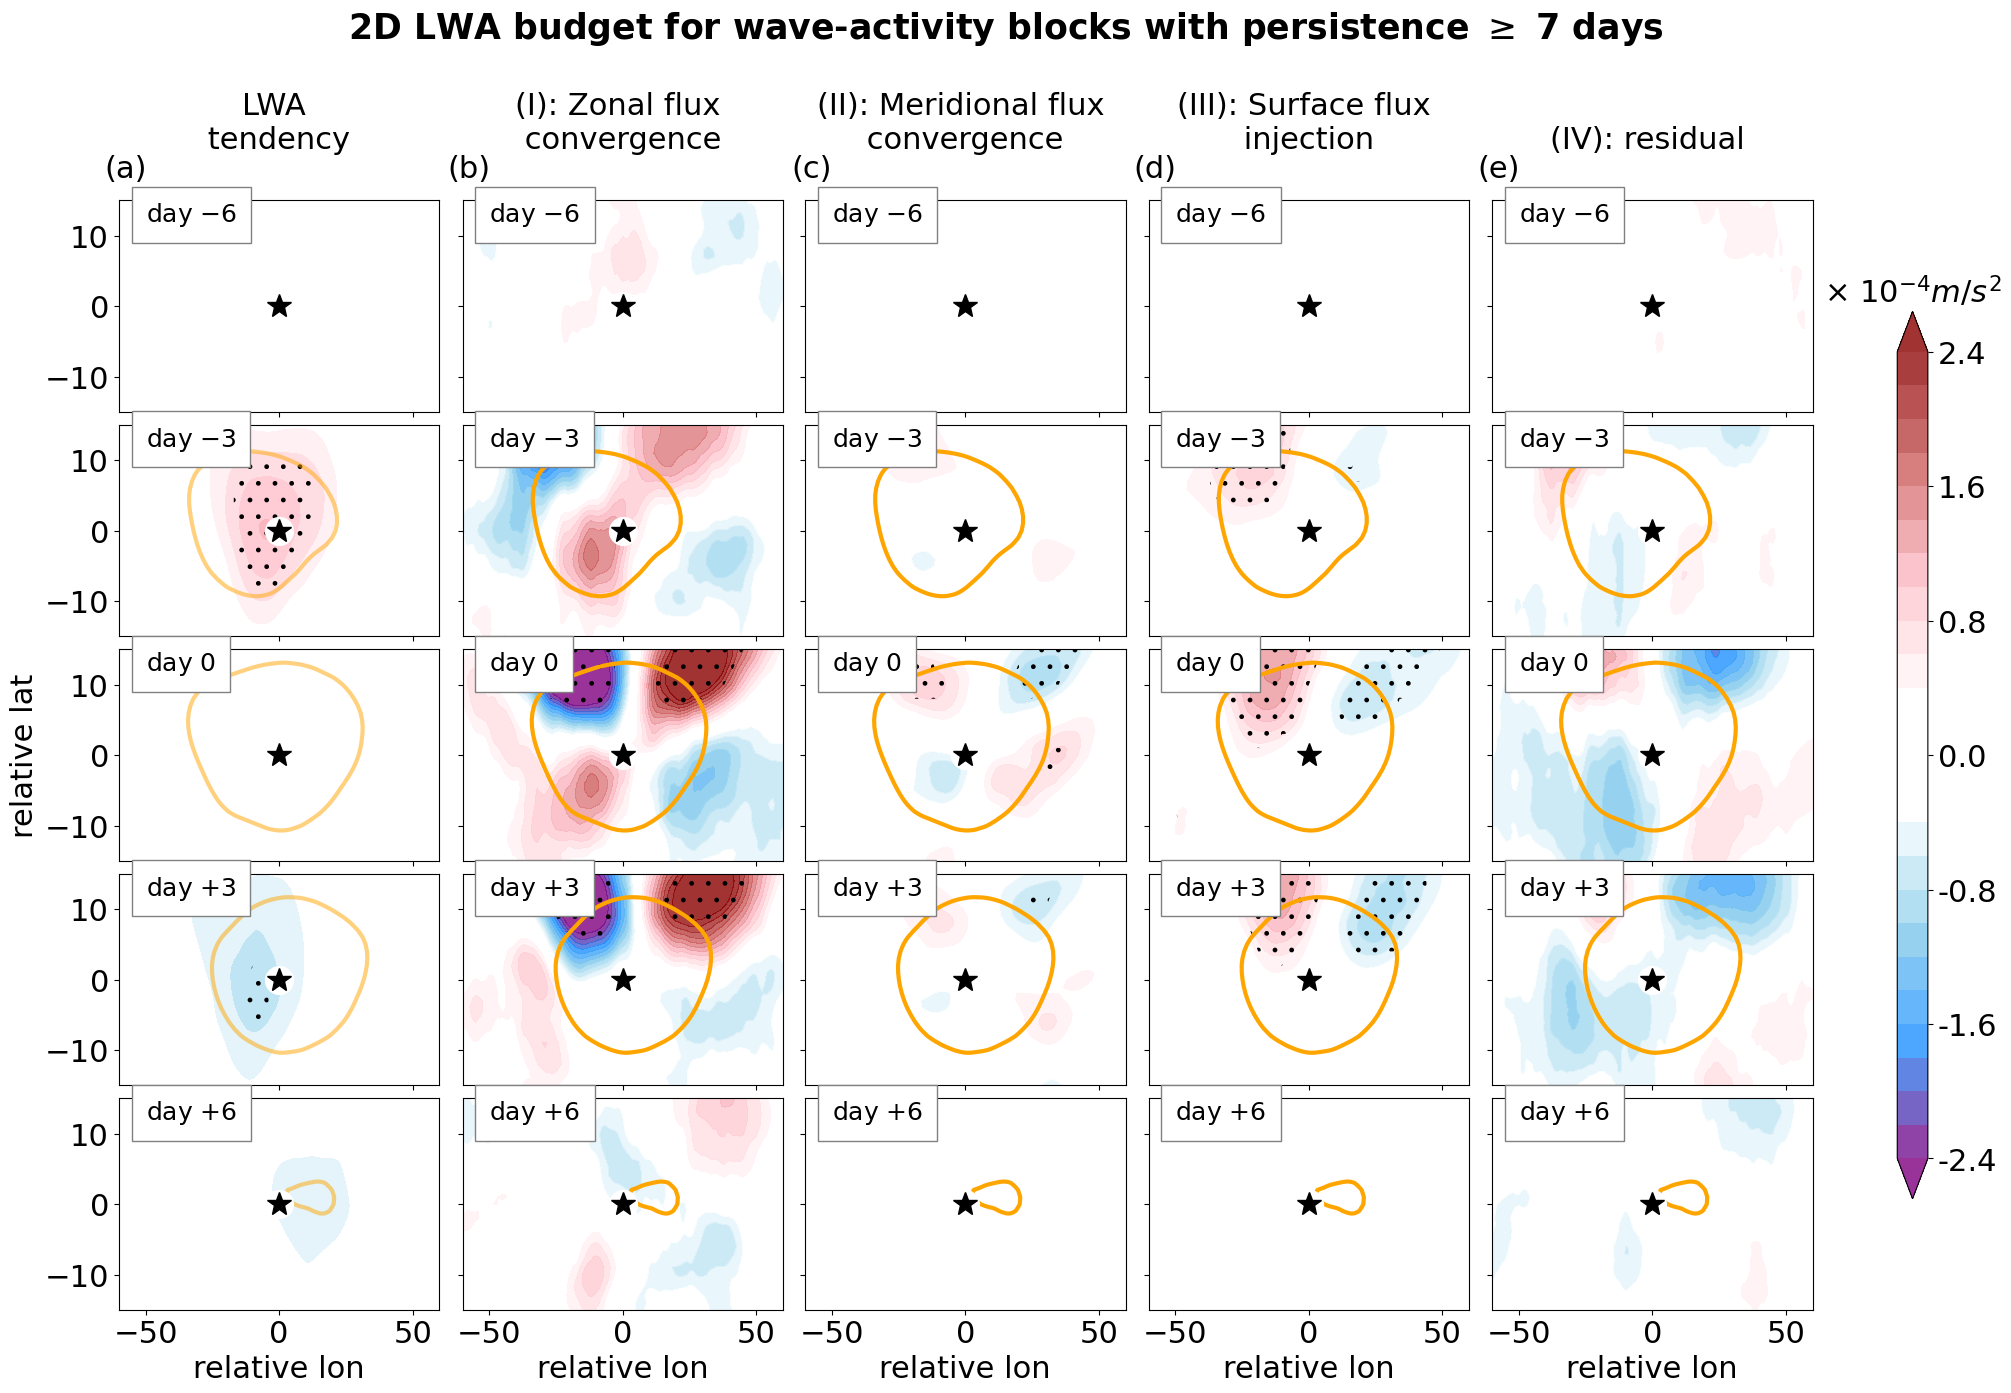

In [65]:
%timeit

LOCATION = 'global composites'

cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", 
        ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

py.rcParams.update({'hatch.color': 'k', 'hatch.linewidth':1})
fig, dictionary, bootstrap_dictionary =   plot_WA_budget_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*1.0, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=2.0*1e3,  mag=2e2, nx = 10, ny = 3, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=0, fontsize=22, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], hatches=['.'], gap=3, \
                                          col_frac=20, row_frac=1.0)

# fig.suptitle(r'2D LWA budget for wave-activity blocks with persistence $\geq$ 7 days', \
#                 fontsize=25, color='k', y=1.06, fontweight='bold')    
dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'LWA_budget_2d_all.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'LWA_budget_2d_all.pdf', bbox_inches='tight')


In [69]:
# dictionary['BLOCK_window_list_dAdt_full_synoptic'].shape

In [76]:
def plot_WA_flux_convergence_evolution_for_a_region_with_vectors(\
                                          regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], LOCATION='North Atlantic', \
                                          lrange  = np.arange(-1.4, 1.5, 0.1), days = [8, 9], cmap1=cmap1, budget_type = 'LWA budget',
                                          vector_scale=50,  mag=2, nx = 4, ny = 1, width=0.00015*100, \
                                          fontsize=30, Nday_extra=0, Nday_less=3, block_type='all_blocks', hatches=['/'], \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[30, 70], gap=2, col_frac=12, row_frac=1.5, xloc=0.70, yloc=0.8):

    
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_budget', \
                                                 dictionary = {}, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
        
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'unfiltered_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
            
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)          

            
            boostrap_dictionary={}
            boostrap_dictionary['BLOCK_window_list_dAdt_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dxF_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF_full_synoptic_stats_.hkl')   
            boostrap_dictionary['BLOCK_window_list_dxF1_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF1_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dxF2_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF2_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dxF3_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF3_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dyEPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dyEPy_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dzEPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dzEPz_full_synoptic_stats_.hkl')
            
            
            
            boostrap_dictionary['BLOCK_window_list_A_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_F_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_F1_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F1_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F2_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F2_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F3_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F3_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F_EPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPy_full_synoptic_stats_.hkl')                        
            boostrap_dictionary['BLOCK_window_list_F_EPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPz_full_synoptic_stats_.hkl')

            
            
            def bootstrap_condition(key_field = 'BLOCK_window_list_U300_full', CI=CI, evolve = 0 ):
                    
                    main_field = M0(dictionary[key_field])
                    
                    
                    
                    low, high = CI
                    
                    percentile_low  = M0(boostrap_dictionary[key_field]['percentile'][str(low)])
                    percentile_high = M0(boostrap_dictionary[key_field]['percentile'][str(high)])
                    
                    significance = np.ones(main_field[evolve,...].shape)
                    
                    condition1 = ((percentile_high[evolve,...]-main_field[evolve,...]) > 0)
                    condition2 = ((percentile_low[evolve,...]-main_field[evolve,...])  < 0)
                    condition  = condition1 & condition2
                    
                    mask = np.ma.masked_where( condition , significance, np.nan)

                    return mask
                

            py.rcParams['text.usetex'] = False

            # Nrow = 10 ### dictionary['BLOCK_window_list_U300_full'].shape[1]
            loni, lati = dictionary['coord']['loni'], dictionary['coord']['lati'] 
            block_size = dictionary['block_size']
            
            
            day        = int(np.mean(days))
            A          = dictionary['BLOCK_window_list_A_full_unfiltered']
            peak_time  = A.shape[1]//2 - 1
            start_time = peak_time - day//2 + Nday_less - Nday_extra
            end_time   = peak_time + day//2 - Nday_less + Nday_extra


            timing   = slice(start_time, end_time+1)
            lag_time = np.arange(start_time, end_time+1, 1)
            lag_time = lag_time - lag_time.mean()

            def M0(Y):
                
                Z = Y[:,  timing, ...]*1e4
                return np.nanmean(Z, axis=0)
                        
            
            A             = M0(dictionary['BLOCK_window_list_A_full_unfiltered'])*1e-4
            
            dAdt          = M0(dictionary['BLOCK_window_list_dAdt_full_synoptic'])
            dF_dx         = M0(dictionary['BLOCK_window_list_dxF_full_synoptic'])
            dEPy_dy       = M0(dictionary['BLOCK_window_list_dyEPy_full_synoptic'])
            dEPz_dz       = M0(dictionary['BLOCK_window_list_dzEPz_full_synoptic'])

            dF1_dx        = M0(dictionary['BLOCK_window_list_dxF1_full_synoptic'])
            dF2_dx        = M0(dictionary['BLOCK_window_list_dxF2_full_synoptic'])
            dF3_dx        = M0(dictionary['BLOCK_window_list_dxF3_full_synoptic'])
            
            residual      = dAdt- (dF_dx+dEPy_dy+dEPz_dz)
            
            
            F1            = M0(dictionary['BLOCK_window_list_F1_full_synoptic'])*1e-4
            F2            = M0(dictionary['BLOCK_window_list_F2_full_synoptic'])*1e-4
            F3            = M0(dictionary['BLOCK_window_list_F3_full_synoptic'])*1e-4
            F             = M0(dictionary['BLOCK_window_list_F_full_synoptic'])*1e-4
            EPy           = M0(dictionary['BLOCK_window_list_F_EPy_full_synoptic'])*1e-4
            EPz           = M0(dictionary['BLOCK_window_list_F_EPz_full_synoptic'])*1e-4
            
            
                     
            uu =   +   F[..., ::ny, ::nx]
            vv =   - EPy[..., ::ny, ::nx]
            lx, ly = loni[::nx], lati[::ny]
            speed = np.sqrt(uu**2 + vv**2)
            
                         
            fig, axs = py.subplots(len((np.arange(0, (len(lag_time)), gap))), 3,  figsize=(col_frac, int(row_frac*len(lag_time))), \
                                   sharex=True, sharey=True, constrained_layout=True)

            enum = -1

            for evolve in (np.arange(0, (len(lag_time)), gap)):

                    enum = enum+1
                    
                    
                    im1 = \
                    axs[enum, 0].contourf(loni, lati, dF_dx[evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8);
                    axs[enum, 0].contour(loni, lati,A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 

                    
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 0].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both',); #py.colorbar()  
                    ## mask unsignificant areas
    
    
                    uu =   +   F[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]
                    ## mask unsignificant areas
                    masked_uu =  bootstrap_condition(key_field = 'BLOCK_window_list_F_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 0].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

                    
                    
                    im2 = \
                    axs[enum, 1].contourf(loni, lati, dF1_dx [evolve, ...] + dF3_dx [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 1].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 

                    
                    ## mask unsignificant areas
                    mask1 =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF1_full_synoptic', CI=CI, evolve = evolve )
                    mask3 =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF3_full_synoptic', CI=CI, evolve = evolve )
                    mask = (mask1)
#                     mask[mask>1e-5] = 1
                    axs[enum, 1].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both',); #py.colorbar()  
                    ## mask unsignificant areas
                    
            
                    ## mask unsignificant areas
                    uu =   +  F1[..., ::ny, ::nx] + F3[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]
                    masked_uu =  (bootstrap_condition(key_field = 'BLOCK_window_list_F1_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]\
                                 +bootstrap_condition(key_field = 'BLOCK_window_list_F3_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx])
                    
                    masked_uu[masked_uu>0] = 1
                    masked_uu = masked_uu*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 1].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

                    
                    
                    im3 = \
                    axs[enum, 2].contourf(loni, lati, dF2_dx [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 2].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=1); 
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF2_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 2].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='both',); #py.colorbar()  
                    ## mask unsignificant areas
                    
                    ## mask unsignificant areas
                    uu =   +   F2[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]*0
                    masked_uu =  bootstrap_condition(key_field = 'BLOCK_window_list_F2_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 2].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

                
                    for AX in axs[enum, :]:
                        if lag_time[evolve]>0:
                            sign='+'
                        elif lag_time[evolve]<0:
                            sign='-'
                        else:
                            sign=''
                        AX.text(-50, 12, r"day $%s%d$"%(sign, np.abs(lag_time[evolve])), \
                                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10, 'edgecolor':'gray'}, \
                                fontsize=fontsize-4, color='k',)

                                                             
            for ax in axs.flatten():
                ax.set_xlim(np.min(loni), np.max(loni))
                ax.set_ylim(np.min(lati), np.max(lati))
                ax.tick_params(labelsize = fontsize, colors ='k') 
                ax.plot(*(0,0), 'wo',  ms=20)
                ax.plot(*(0,0), 'k*',  ms=18)


            axs[0, 0].quiverkey(vec, xloc, yloc, mag, r'%1d $m^2/s^2$'%(mag), labelpos='N', coordinates='figure', \
                                   fontproperties = {'size':fontsize}, labelcolor='k',  linewidth = 2) 


            axs[0, 0].set_title('Zonal flux \n convergence \n '    ,   fontsize=fontsize+2, y=1.05)
            axs[0, 1].set_title('Linear component \n'        ,   fontsize=fontsize+2, y=1.05)
            axs[0, 2].set_title('Nonlinear component \n' ,   fontsize=fontsize+2, y=1.05)
            
            for AX, label in zip(axs[0,:], ['(a)', '(b)', '(c)', '(d)', '(e)']):
                AX.text(0.02, 1.20, label,  horizontalalignment='center', verticalalignment='center', \
                        transform = AX.transAxes, fontsize=fontsize+2)

            cbar = fig.colorbar(im1, ax=axs.ravel(), location='right',  shrink=0.8, aspect=24, pad=0.1)
            cbar.ax.tick_params(labelsize=fontsize)
            loc= lrange[::4]  #(np.linspace((lrange[0]),(lrange[-1]), 8))
            cbar.set_ticks(loc)
            fmt='%1.1f'
            cbar.set_ticklabels([fmt%i for i in loc])
            cbar.ax.set_title(r'$\times$ $10^{-4} m/s^2$',fontsize=fontsize)
                       

            for AX in tqdm([axs[axs.shape[0]//2,0]]):
                AX.set_ylabel('relative lat', fontsize=fontsize)
                
            for AX in tqdm(axs[-1,:]):
                AX.set_xlabel('relative lon', fontsize=fontsize)
                
            
            BLOCK_TYPE = block_type if block_type in ['cyclonic', 'anticyclonic'] else 'wave-activity blocks'

            fig.suptitle(r'Decomposition of zonal flux convergence and flux vectors'+ '\n'+ r'for %s with persistence $\geq$ 7 days'%(BLOCK_TYPE)+ '\n', \
                         fontsize=fontsize+3, color='k', y=1.10, fontweight='bold')                   

            return fig


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18236.10it/s]


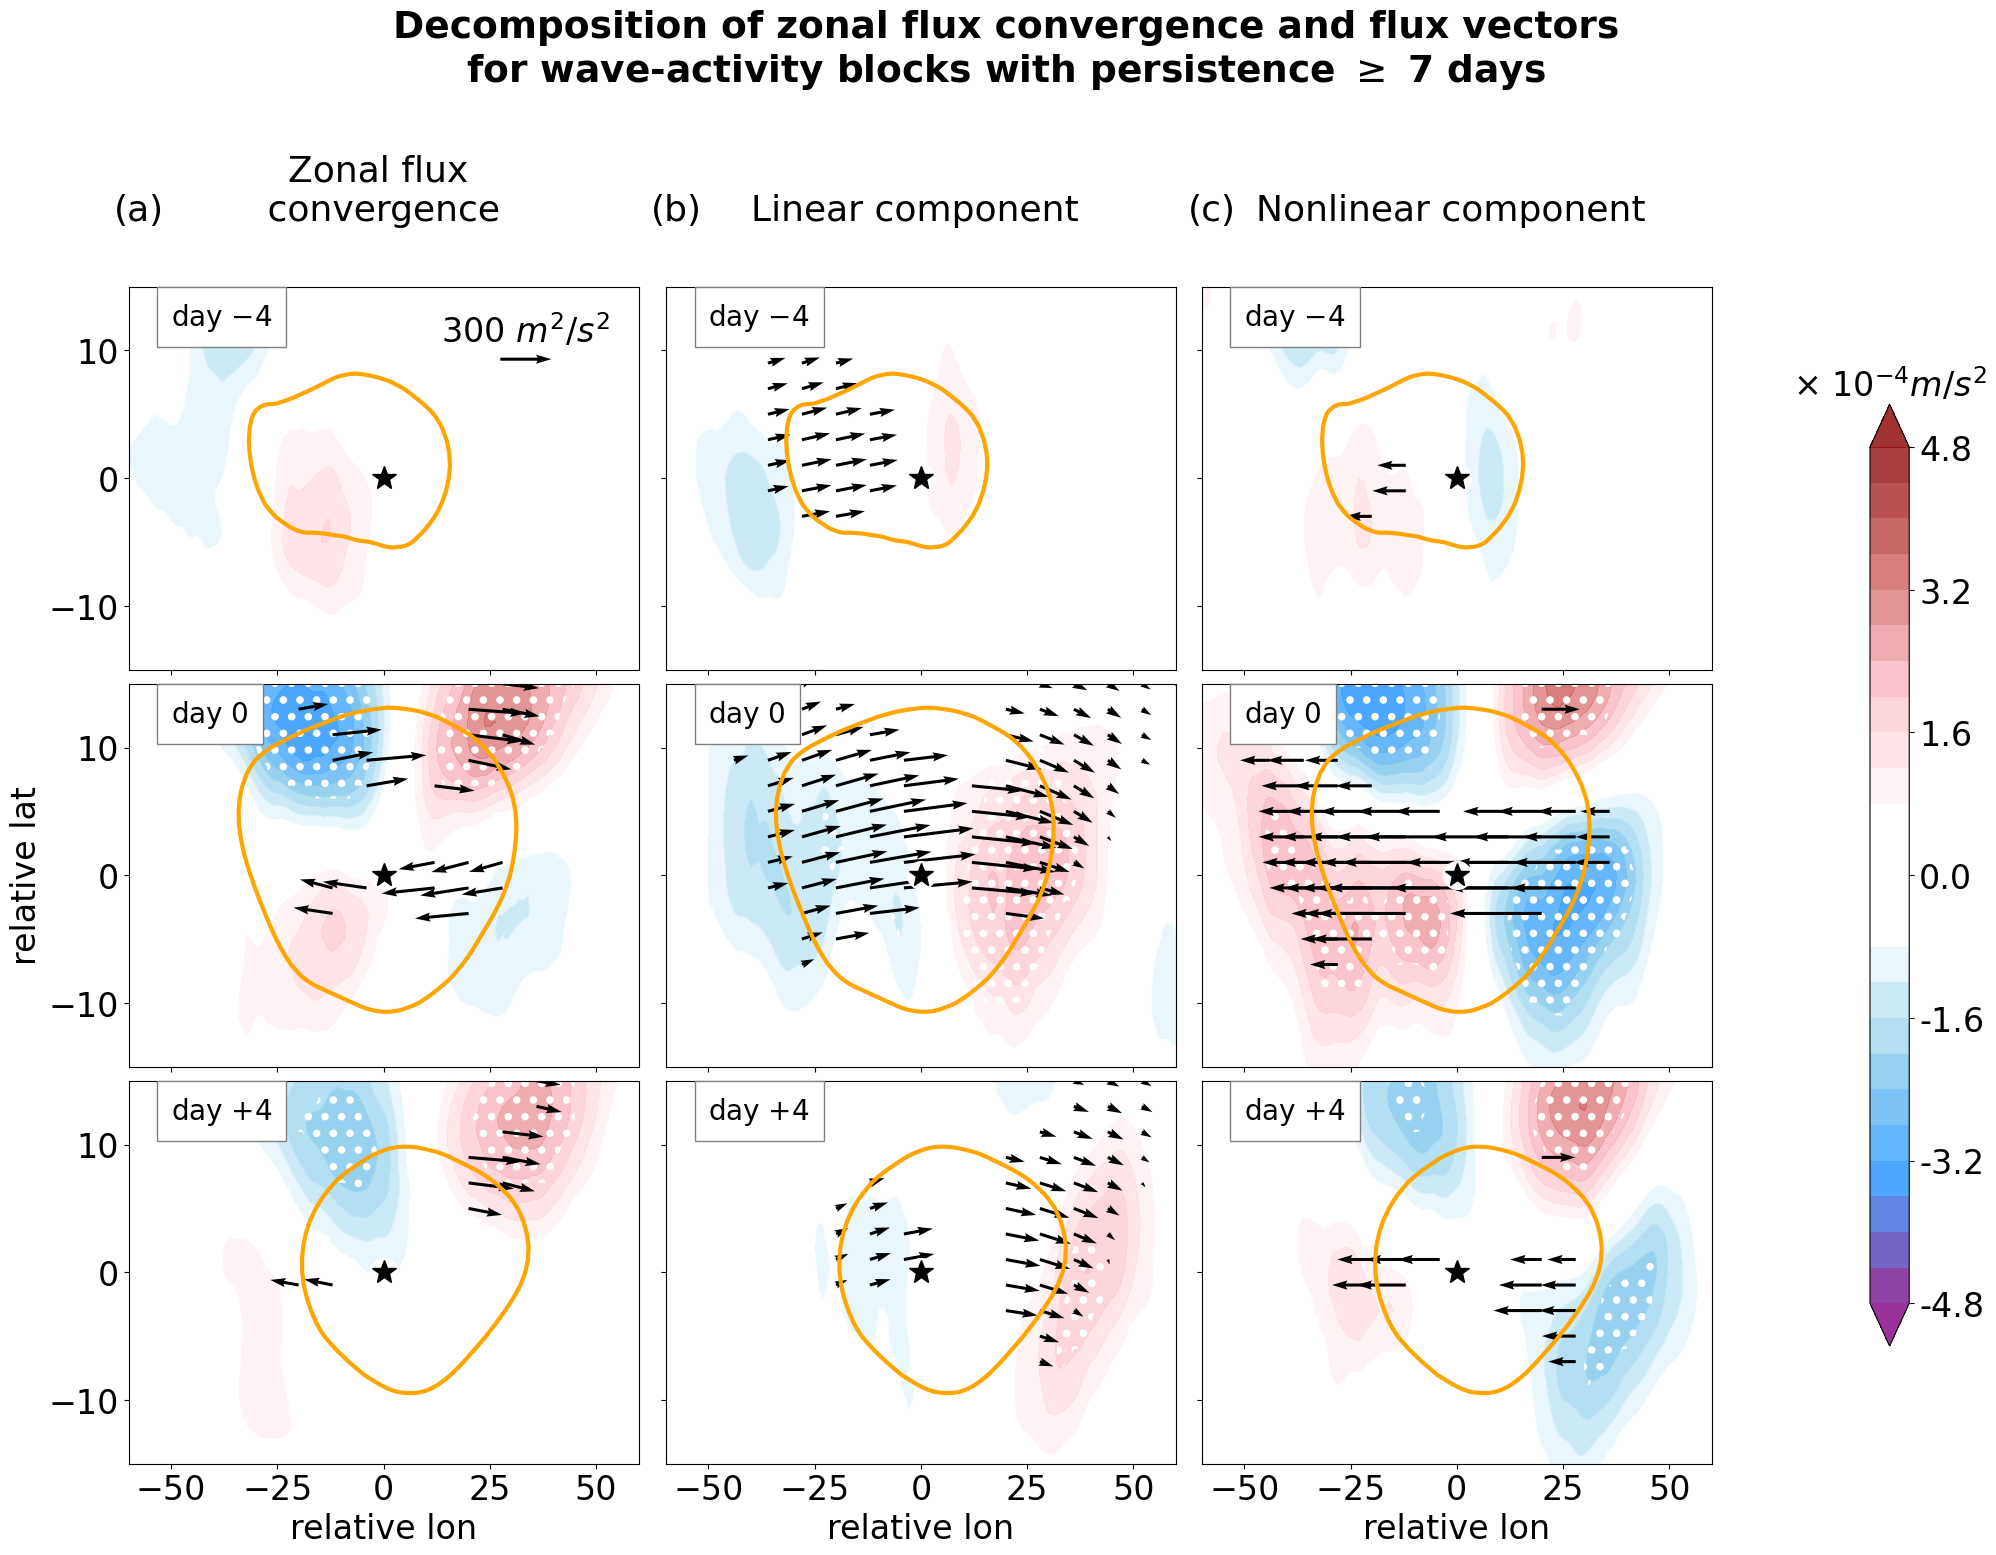

In [77]:
%timeit

LOCATION = 'global composites'

cmap     = matplotlib.colors.LinearSegmentedColormap.from_list("", 
           ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

py.rcParams.update({'hatch.color': 'white', 'hatch.linewidth':3})
fig      = plot_WA_flux_convergence_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*2, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=3.0*1e3,  mag=3e2, nx = 8, ny = 2, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=2, fontsize=24, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[25,75], hatches=['.'], gap=4, \
                                          col_frac=20, row_frac=1.6, xloc=0.26, yloc=0.85)

dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'LWA_flux_decomposition_2d_short.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'LWA_flux_decomposition_2d_short.pdf', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15847.50it/s]


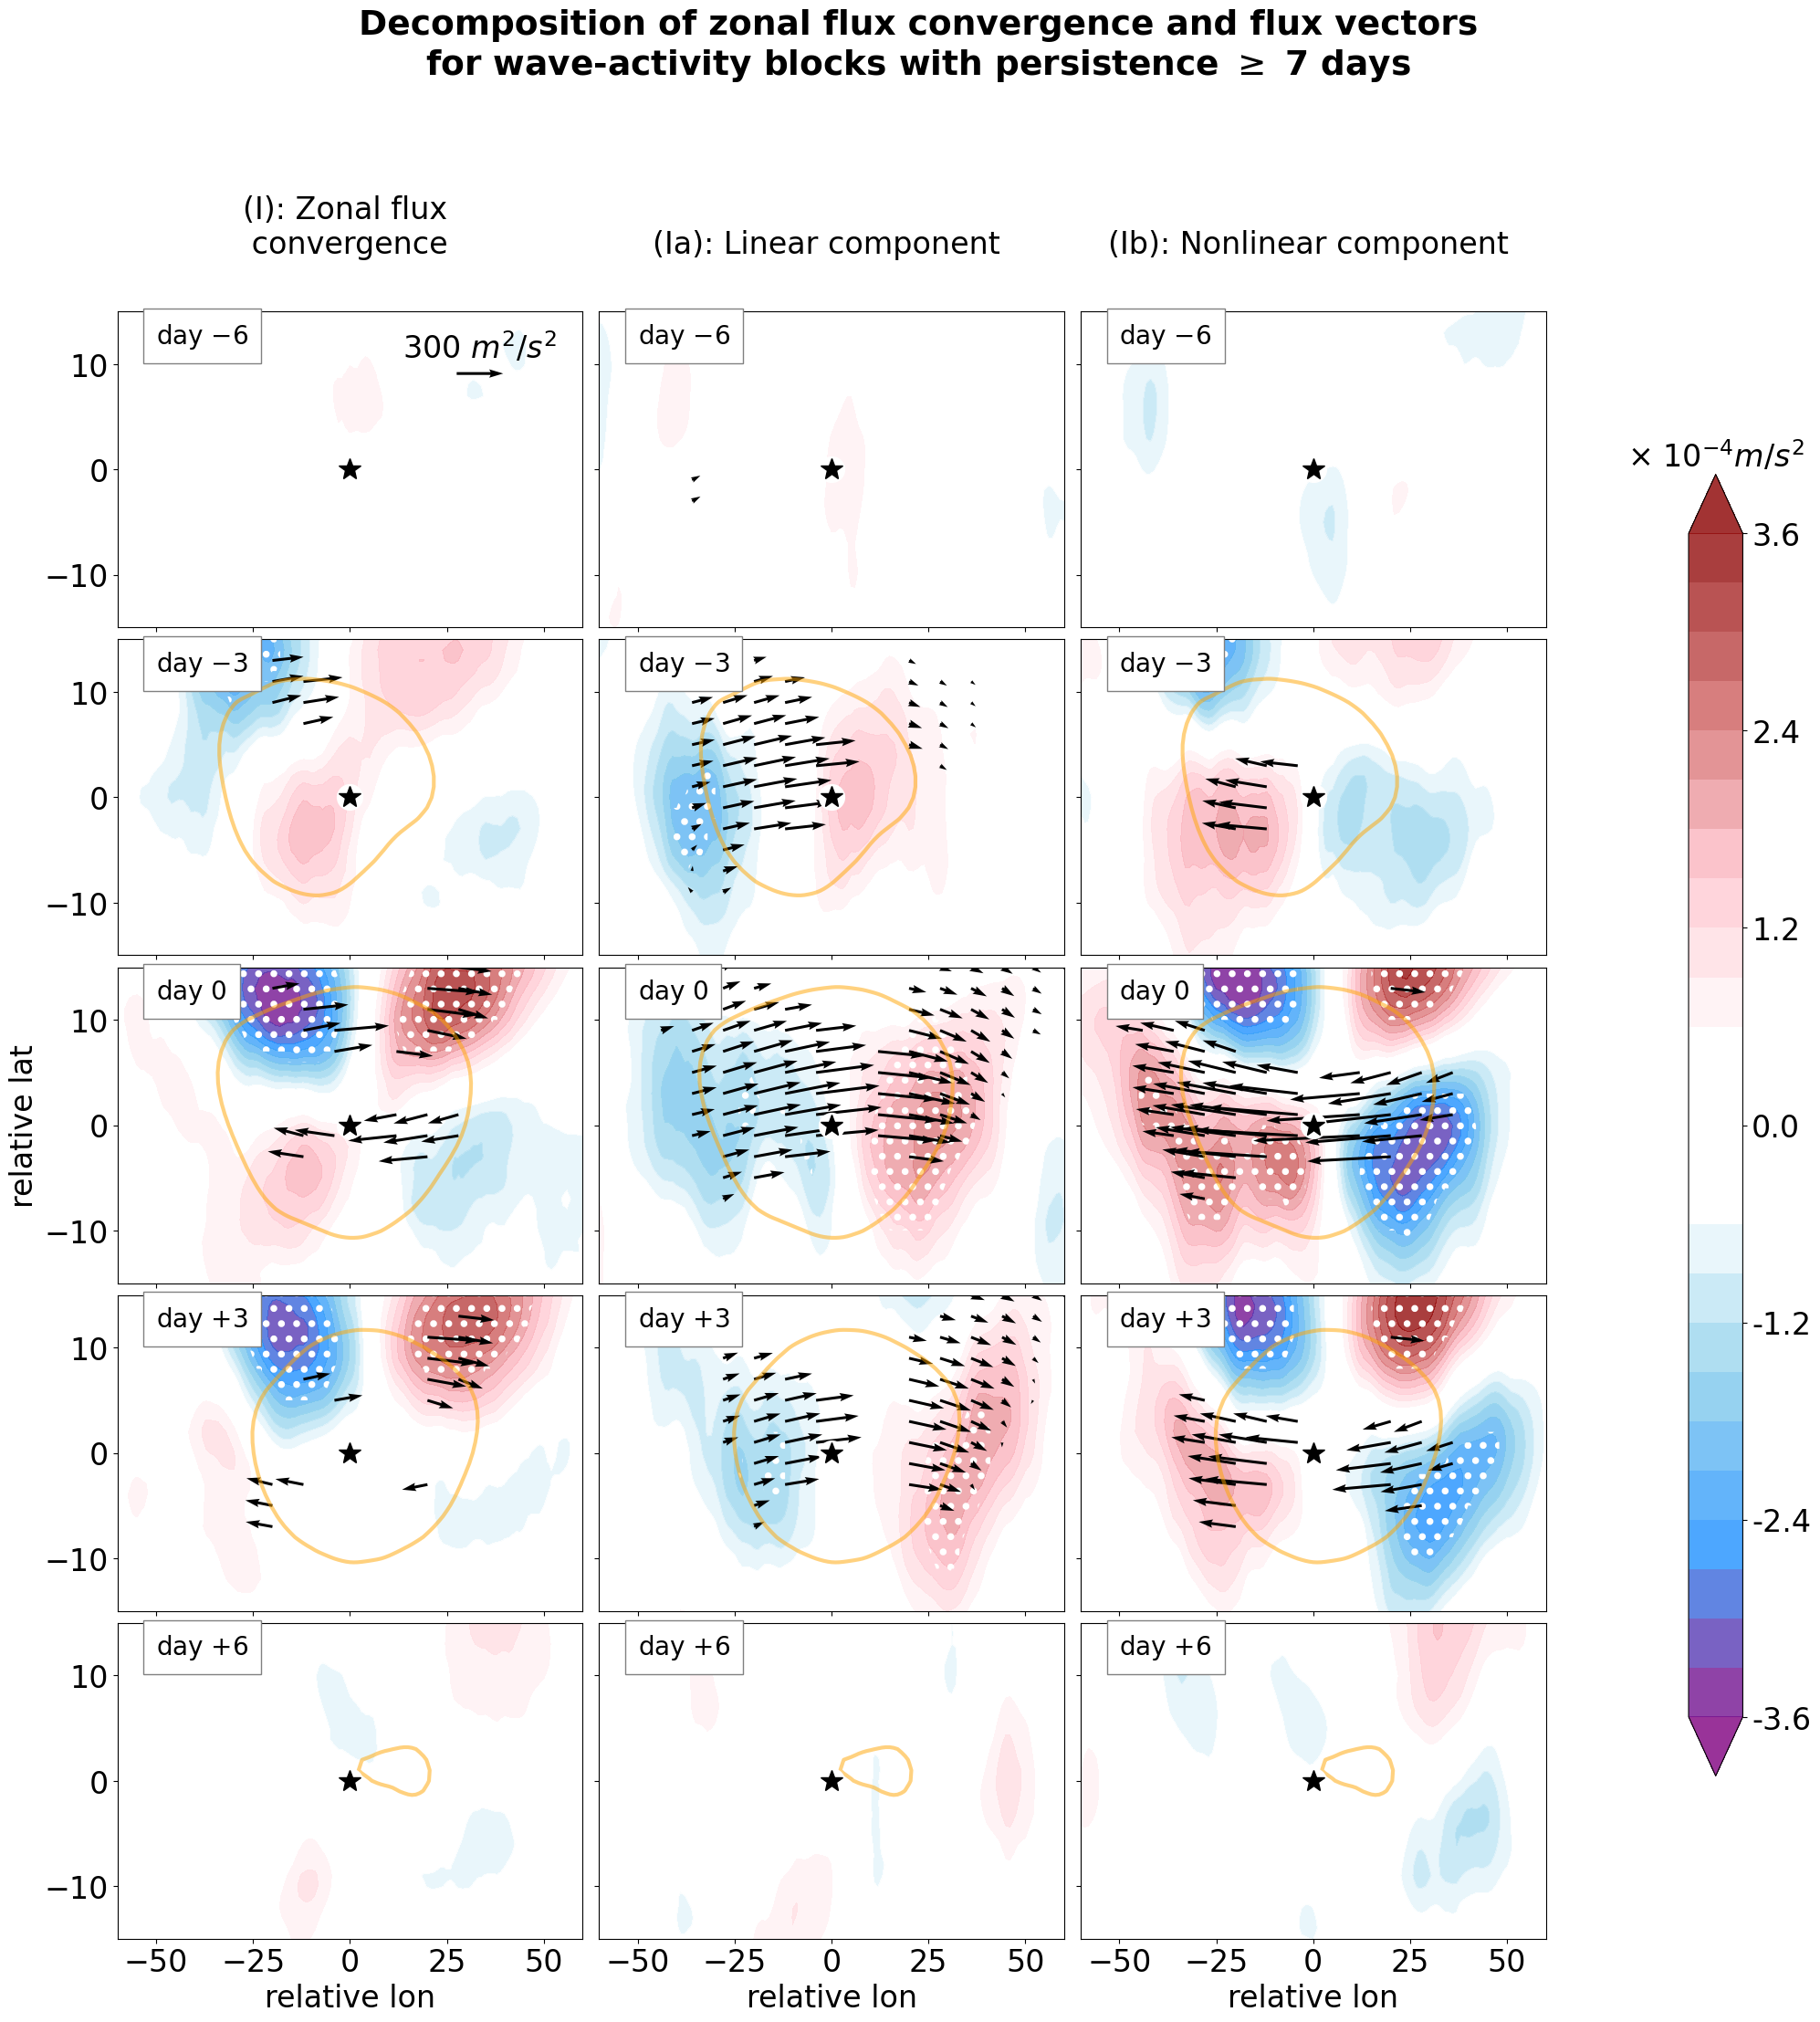

In [41]:
%timeit

LOCATION = 'global composites'

cmap     = matplotlib.colors.LinearSegmentedColormap.from_list("", 
           ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

py.rcParams.update({'hatch.color': 'white', 'hatch.linewidth':3})
fig      = plot_WA_flux_convergence_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*1.5, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=3.0*1e3,  mag=3e2, nx = 8, ny = 2, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=0, fontsize=24, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[25,75], hatches=['.'], gap=3, \
                                          col_frac=20, row_frac=1.6, xloc=0.26, yloc=0.90)

dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'LWA_flux_decomposition_2d_long.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'LWA_flux_decomposition_2d_long.pdf', bbox_inches='tight')


In [29]:
pwd

'/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/2023_notebooks_for_paper/finalizing'

100%|██████████| 5/5 [00:00<00:00, 25795.23it/s]


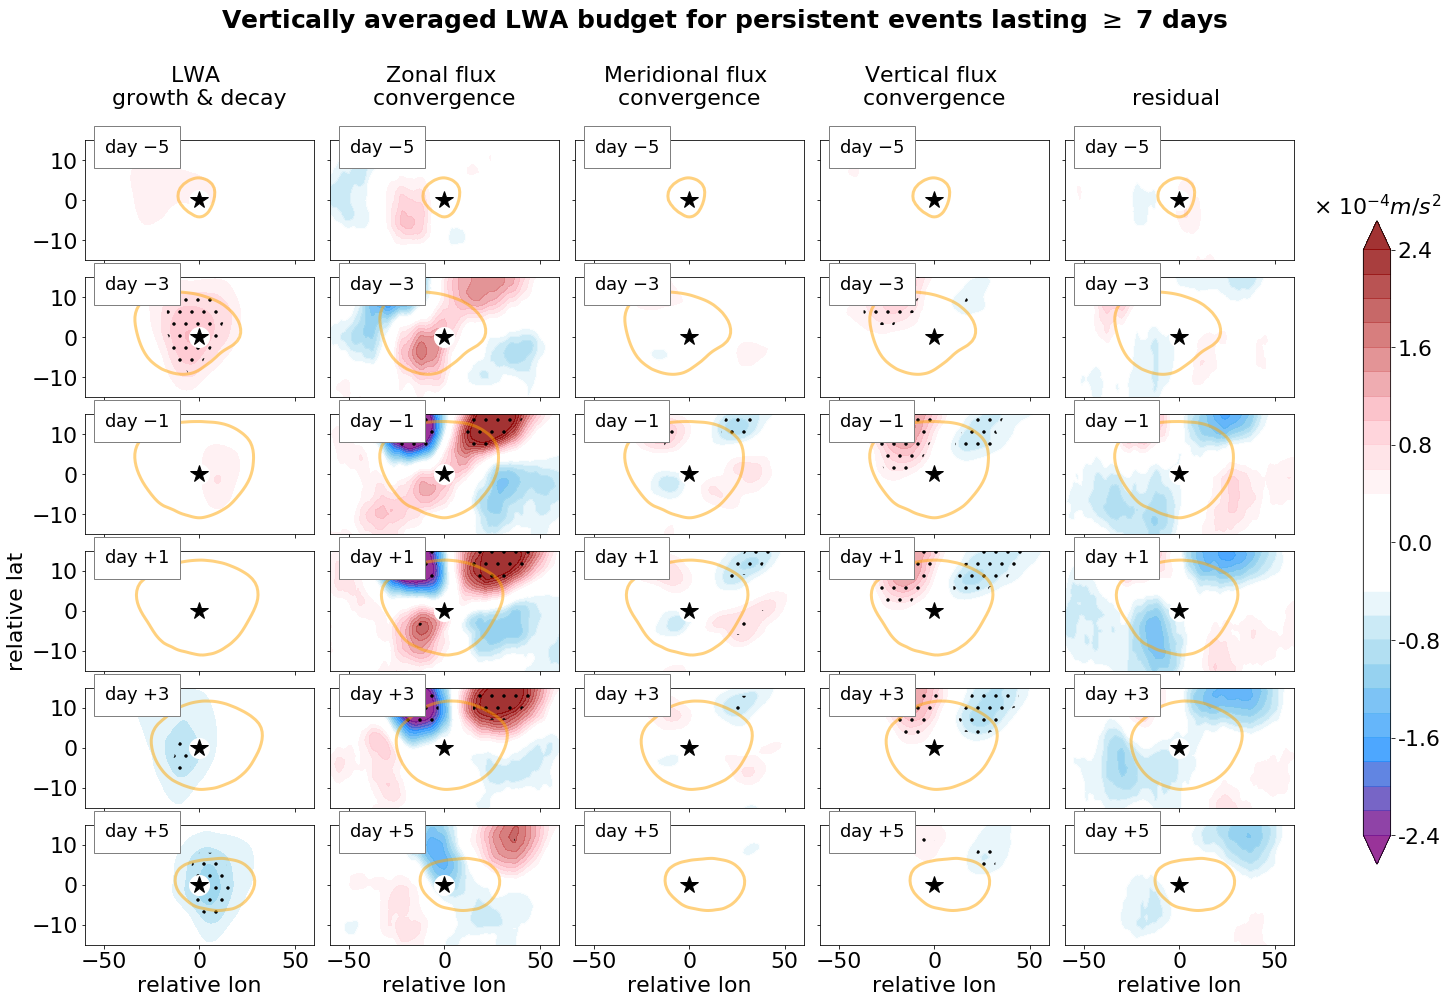

In [19]:
%timeit

LOCATION = 'global composites'

cmap  = matplotlib.colors.LinearSegmentedColormap.from_list("", 
        ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

fig = plot_WA_budget_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*1.0, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=2.0*1e3,  mag=2e2, nx = 10, ny = 3, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=1, fontsize=22, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], hatches=['.'], gap=2, \
                                          col_frac=20, row_frac=1.2)

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/2023_paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'LWA_budget_2d_all.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'LWA_budget_2d_all.pdf', bbox_inches='tight')


In [18]:
def plot_WA_flux_convergence_evolution_for_a_region_with_vectors(\
                                          regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], LOCATION='North Atlantic', \
                                          lrange  = np.arange(-1.4, 1.5, 0.1), days = [8, 9], cmap1=cmap1, budget_type = 'LWA budget',
                                          vector_scale=50,  mag=2, nx = 4, ny = 1, width=0.00015*100, \
                                          fontsize=30, Nday_extra=0, Nday_less=3, block_type='all_blocks', hatches=['/'], \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[30, 70], gap=2, col_frac=12, row_frac=1.5, xloc=0.70, yloc=0.8):

    

            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_budget', \
                                                 dictionary = {}, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
        
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'unfiltered_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
            
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)          

            
            boostrap_dictionary={}
            boostrap_dictionary['BLOCK_window_list_dAdt_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dAdt_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dxF_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF_full_synoptic_stats_.hkl')   
            boostrap_dictionary['BLOCK_window_list_dxF1_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF1_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dxF2_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF2_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dxF3_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dxF3_full_synoptic_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_dyEPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dyEPy_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_dzEPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_budget/BLOCK_window_list_dzEPz_full_synoptic_stats_.hkl')
            
            
            
            boostrap_dictionary['BLOCK_window_list_A_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_F_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_full_synoptic_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_F1_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F1_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F2_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F2_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F3_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F3_full_synoptic_stats_.hkl')        
            boostrap_dictionary['BLOCK_window_list_F_EPy_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPy_full_synoptic_stats_.hkl')                        
            boostrap_dictionary['BLOCK_window_list_F_EPz_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_F_EPz_full_synoptic_stats_.hkl')

            
            
            def bootstrap_condition(key_field = 'BLOCK_window_list_U300_full', CI=CI, evolve = 0 ):
                    
                    main_field = M0(dictionary[key_field])
                    
                    
                    
                    low, high = CI
                    
                    percentile_low  = M0(boostrap_dictionary[key_field]['percentile'][str(low)])
                    percentile_high = M0(boostrap_dictionary[key_field]['percentile'][str(high)])
                    
                    significance = np.ones(main_field[evolve,...].shape)
                    
                    condition1 = ((percentile_high[evolve,...]-main_field[evolve,...]) > 0)
                    condition2 = ((percentile_low[evolve,...]-main_field[evolve,...])  < 0)
                    condition  = condition1 & condition2
                    
                    mask = np.ma.masked_where( condition , significance, np.nan)

                    return mask
                

            py.rcParams['text.usetex'] = False

            # Nrow = 10 ### dictionary['BLOCK_window_list_U300_full'].shape[1]
            loni, lati = dictionary['coord']['loni'], dictionary['coord']['lati'] 
            block_size = dictionary['block_size']
            
            
            day        = int(np.mean(days))
            A          = dictionary['BLOCK_window_list_A_full_unfiltered']
            peak_time  = A.shape[1]//2 - 1
            start_time = peak_time - day//2 + Nday_less - Nday_extra
            end_time   = peak_time + day//2 - Nday_less + Nday_extra


            timing   = slice(start_time, end_time+1)
            lag_time = np.arange(start_time, end_time+1, 1)
            lag_time = lag_time - lag_time.mean()

            def M0(Y):
                
                Z = Y[:,  timing, ...]*1e4
                return np.nanmean(Z, axis=0)
                        
            
            A             = M0(dictionary['BLOCK_window_list_A_full_unfiltered'])*1e-4
            
            dAdt          = M0(dictionary['BLOCK_window_list_dAdt_full_synoptic'])
            dF_dx         = M0(dictionary['BLOCK_window_list_dxF_full_synoptic'])
            dEPy_dy       = M0(dictionary['BLOCK_window_list_dyEPy_full_synoptic'])
            dEPz_dz       = M0(dictionary['BLOCK_window_list_dzEPz_full_synoptic'])

            dF1_dx        = M0(dictionary['BLOCK_window_list_dxF1_full_synoptic'])
            dF2_dx        = M0(dictionary['BLOCK_window_list_dxF2_full_synoptic'])
            dF3_dx        = M0(dictionary['BLOCK_window_list_dxF3_full_synoptic'])
            
            residual      = dAdt- (dF_dx+dEPy_dy+dEPz_dz)
            
            
            F1            = M0(dictionary['BLOCK_window_list_F1_full_synoptic'])*1e-4
            F2            = M0(dictionary['BLOCK_window_list_F2_full_synoptic'])*1e-4
            F3            = M0(dictionary['BLOCK_window_list_F3_full_synoptic'])*1e-4
            F             = M0(dictionary['BLOCK_window_list_F_full_synoptic'])*1e-4
            EPy           = M0(dictionary['BLOCK_window_list_F_EPy_full_synoptic'])*1e-4
            EPz           = M0(dictionary['BLOCK_window_list_F_EPz_full_synoptic'])*1e-4
            
            
                     
            uu =   +   F[..., ::ny, ::nx]
            vv =   - EPy[..., ::ny, ::nx]
            lx, ly = loni[::nx], lati[::ny]
            speed = np.sqrt(uu**2 + vv**2)
            
                         
            fig, axs = py.subplots(len((np.arange(0, (len(lag_time)), gap))), 3,  figsize=(col_frac, int(row_frac*len(lag_time))), \
                                   sharex=True, sharey=True, constrained_layout=True)

            enum = -1

            for evolve in (np.arange(0, (len(lag_time)), gap)):

                    enum = enum+1
                    
                    
                    im1 = \
                    axs[enum, 0].contourf(loni, lati, dF_dx[evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8);
                    axs[enum, 0].contour(loni, lati,A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=0.5); 

                    
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 0].contourf(loni, lati, mask, hatches=hatches, colors='gray', extend='both', alpha=0.000001); #py.colorbar()  
                    ## mask unsignificant areas
    
    
                    uu =   +   F[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]
                    ## mask unsignificant areas
                    masked_uu =  bootstrap_condition(key_field = 'BLOCK_window_list_F_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 0].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

                    
                    
                    im2 = \
                    axs[enum, 1].contourf(loni, lati, dF1_dx [evolve, ...] + dF3_dx [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 1].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=0.5); 

                    
                    ## mask unsignificant areas
                    mask1 =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF1_full_synoptic', CI=CI, evolve = evolve )
                    mask3 =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF3_full_synoptic', CI=CI, evolve = evolve )
                    mask = (mask1)
#                     mask[mask>1e-5] = 1
                    axs[enum, 1].contourf(loni, lati, mask, hatches=hatches, colors='gray', extend='both', alpha=0.000001); #py.colorbar()  
                    ## mask unsignificant areas
                    
            
                    ## mask unsignificant areas
                    uu =   +  F1[..., ::ny, ::nx] + F3[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]
                    masked_uu =  (bootstrap_condition(key_field = 'BLOCK_window_list_F1_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]\
                                 +bootstrap_condition(key_field = 'BLOCK_window_list_F3_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx])
                    
                    masked_uu[masked_uu>0] = 1
                    masked_uu = masked_uu*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 1].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

                    
                    
                    im3 = \
                    axs[enum, 2].contourf(loni, lati, dF2_dx [evolve, ...], \
                                lrange, cmap=cmap1, extend='both', alpha=0.8); 
                    axs[enum, 2].contour(loni, lati,  A[evolve, ...], \
                                [65], colors='orange', linewidths=3, alpha=0.5); 
                    
                    ## mask unsignificant areas
                    mask =  bootstrap_condition(key_field = 'BLOCK_window_list_dxF2_full_synoptic', CI=CI, evolve = evolve )
                    axs[enum, 2].contourf(loni, lati, mask, hatches=hatches, colors='gray', extend='both', alpha=0.000001); #py.colorbar()  
                    ## mask unsignificant areas
                    
                    ## mask unsignificant areas
                    uu =   +   F2[..., ::ny, ::nx]
                    vv =   - EPy[..., ::ny, ::nx]
                    masked_uu =  bootstrap_condition(key_field = 'BLOCK_window_list_F2_full_synoptic',     CI=CI_vec, evolve = evolve )[::ny, ::nx]*uu[evolve, ...]
                    masked_vv =  bootstrap_condition(key_field = 'BLOCK_window_list_F_EPy_full_synoptic', CI=CI_vec, evolve = evolve )[::ny, ::nx]*vv[evolve, ...]
                    ## mask unsignificant areas               
                    vec = axs[enum, 2].quiver(lx, ly, masked_uu, masked_vv, minlength=0, \
                                               color='k', scale=vector_scale, width=width)

#                     axs[enum, 2].quiverkey(vec, 0.16, 1.01, mag, r'%1d $m^2/s^2$'%(mag), labelpos='N', coordinates='figure', \
#                                            fontproperties = {'size':fontsize}, labelcolor='k',  linewidth = 2) 
                
                    for AX in axs[enum, :]:
                        if lag_time[evolve]>0:
                            sign='+'
                        elif lag_time[evolve]<0:
                            sign='-'
                        else:
                            sign=''
                        AX.text(-50, 12, r"day $%s%d$"%(sign, np.abs(lag_time[evolve])), \
                                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10, 'edgecolor':'gray'}, \
                                fontsize=fontsize-4, color='k',)

                                                             
            for ax in axs.flatten():
                ax.set_xlim(np.min(loni), np.max(loni))
                ax.set_ylim(np.min(lati), np.max(lati))
                ax.tick_params(labelsize = fontsize, colors ='k') 
                ax.plot(*(0,0), 'wo',  ms=20)
                ax.plot(*(0,0), 'k*',  ms=18)


            axs[0, 0].quiverkey(vec, xloc, yloc, mag, r'%1d $m^2/s^2$'%(mag), labelpos='N', coordinates='figure', \
                                   fontproperties = {'size':fontsize}, labelcolor='k',  linewidth = 2) 


            axs[0, 0].set_title('Zonal flux \n convergence \n '    ,   fontsize=fontsize, y=1.05)
            axs[0, 1].set_title('Linear flux \n convergence \n'        ,   fontsize=fontsize, y=1.05)
            axs[0, 2].set_title('Nonlinear flux \n convergence \n' ,   fontsize=fontsize, y=1.05)

            cbar = fig.colorbar(im1, ax=axs.ravel(), location='right',  shrink=0.8, aspect=24, pad=0.01)
            cbar.ax.tick_params(labelsize=fontsize)
            loc= lrange[::4]  #(np.linspace((lrange[0]),(lrange[-1]), 8))
            cbar.set_ticks(loc)
            fmt='%1.1f'
            cbar.set_ticklabels([fmt%i for i in loc])
            cbar.ax.set_title(r'$\times$ $10^{-4} m/s^2$',fontsize=fontsize)
                       

            for AX in tqdm([axs[axs.shape[0]//2,0]]):
                AX.set_ylabel('relative lat', fontsize=fontsize)
                
            for AX in tqdm(axs[-1,:]):
                AX.set_xlabel('relative lon', fontsize=fontsize)
                
            
            BLOCK_TYPE = block_type if block_type in ['cyclonic', 'anticyclonic'] else 'persistent'
#             fig.suptitle('%s for \n %s blocks from %s \n\n (%d events during DJF, 1979-2021)\n\n'%(\
#                          budget_type, BLOCK_TYPE, LOCATION, dictionary['BLOCK_window_list_A_full_unfiltered'].shape[0]), \
#                          fontsize=fontsize+5, color='maroon', y=1.16)   

            fig.suptitle(r'Decomposition of zonal flux convergence and flux vectors'+ '\n'+ r'for %s events lasting $\geq$ 7 days'%(BLOCK_TYPE)+ '\n', \
                         fontsize=fontsize+3, color='k', y=1.10, fontweight='bold')                   

#           fig.show()
            return fig


100%|██████████| 3/3 [00:00<00:00, 15420.24it/s]


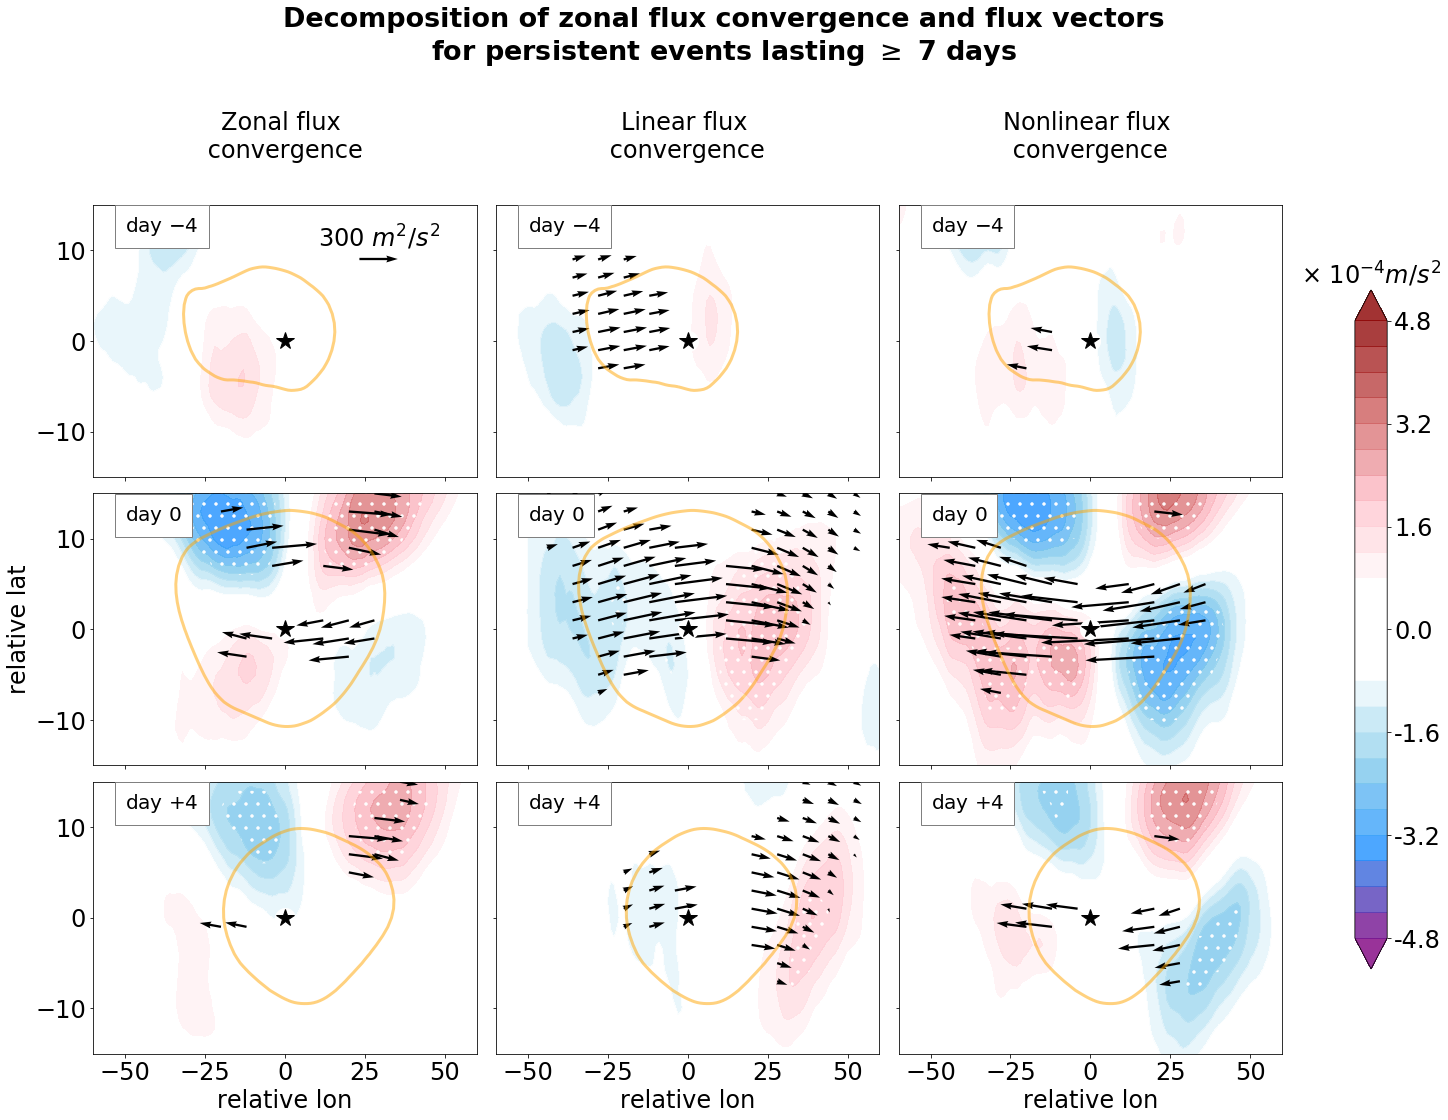

In [26]:
%timeit

LOCATION = 'global composites'

cmap     = matplotlib.colors.LinearSegmentedColormap.from_list("", 
           ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

py.rcParams.update({'hatch.color': 'white', 'hatch.linewidth':1})
fig      = plot_WA_flux_convergence_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*2, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=3.0*1e3,  mag=3e2, nx = 8, ny = 2, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=2, fontsize=24, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[25,75], hatches=['.'], gap=4, \
                                          col_frac=20, row_frac=1.6, xloc=0.26, yloc=0.85)


# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/2023_paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'LWA_flux_decomposition_2d.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'LWA_flux_decomposition_2d.pdf', bbox_inches='tight')

100%|██████████| 3/3 [00:00<00:00, 5302.53it/s]


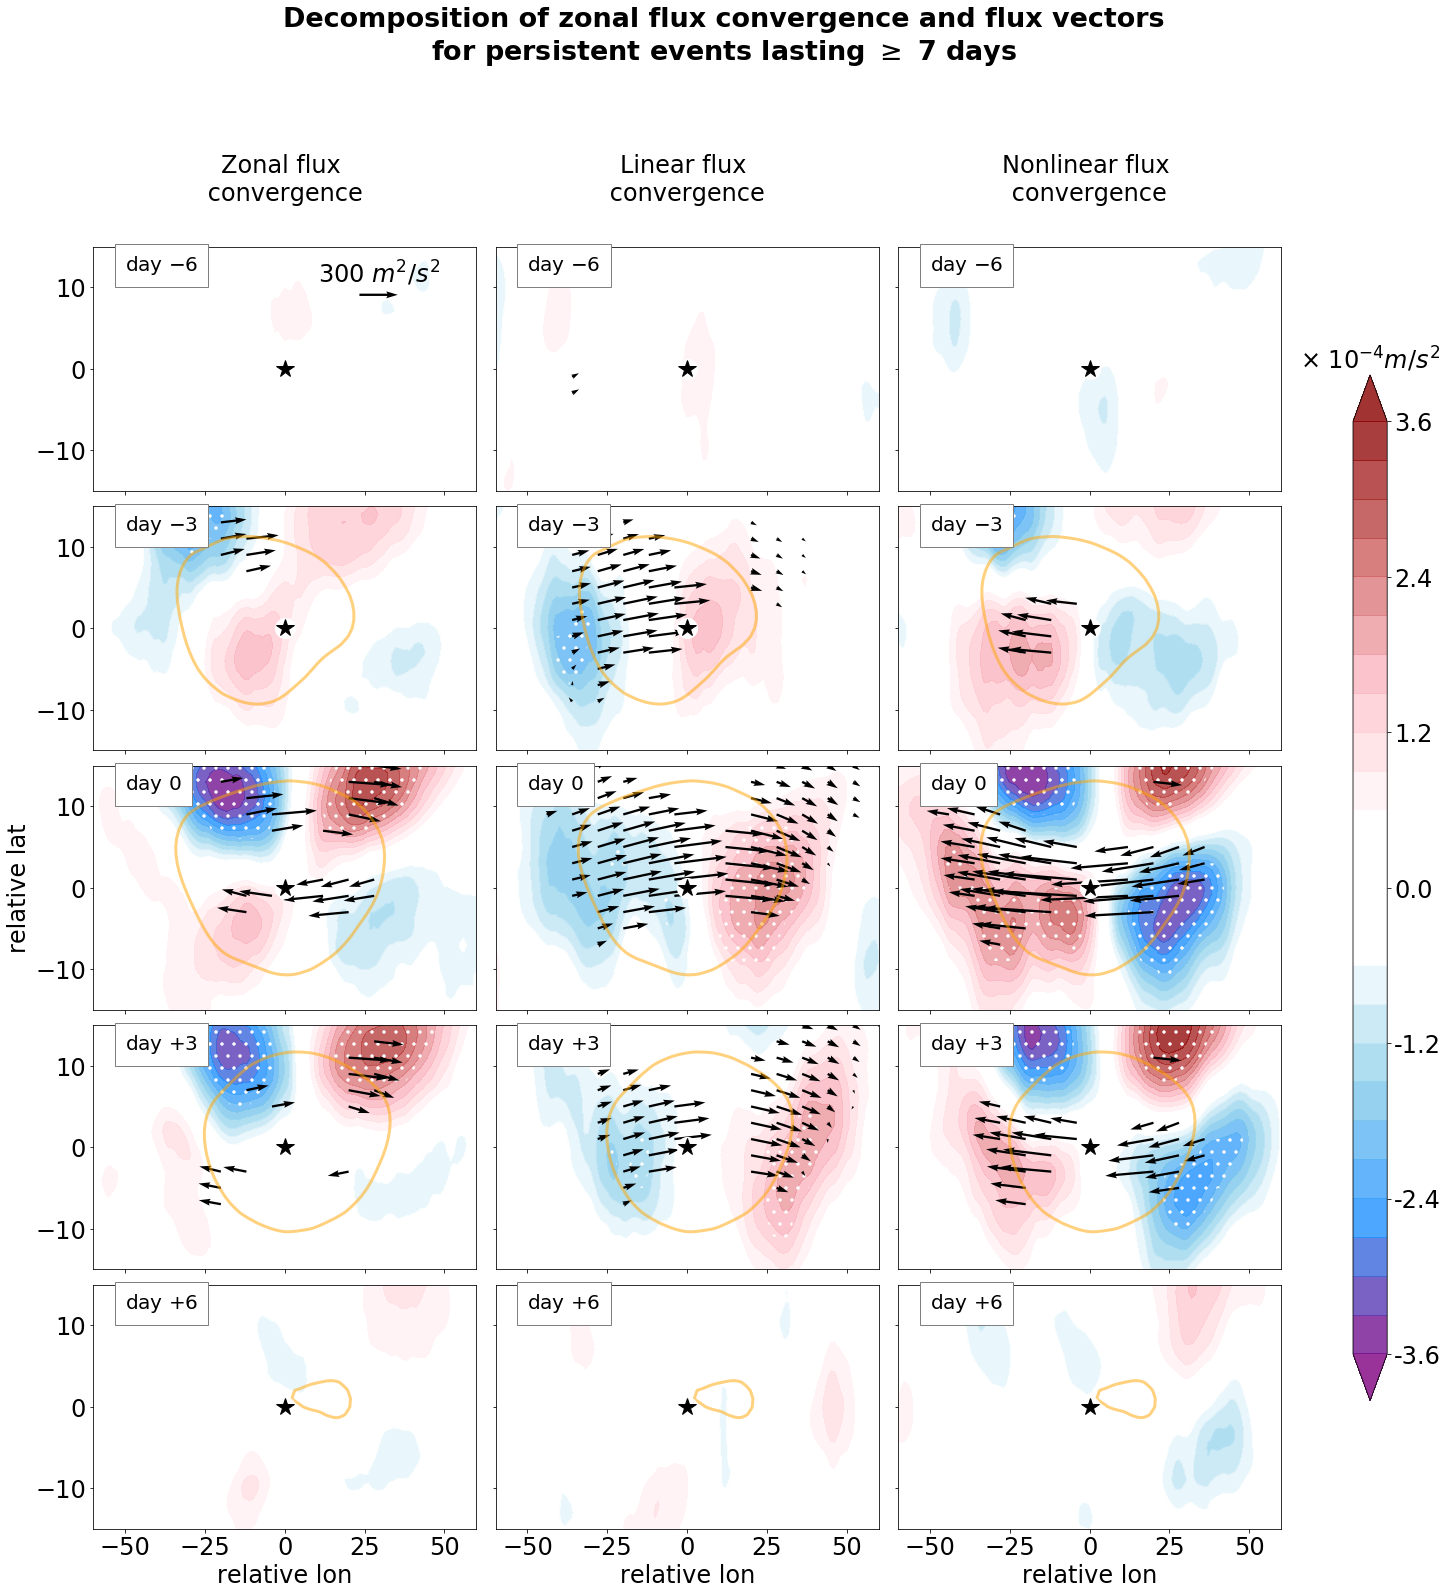

In [29]:
%timeit

LOCATION = 'global composites'

cmap     = matplotlib.colors.LinearSegmentedColormap.from_list("", 
           ["darkred", "indianred", "pink", "white", "white","skyblue", "dodgerblue", "purple"][::-1])

py.rcParams.update({'hatch.color': 'white', 'hatch.linewidth':1})
fig      = plot_WA_flux_convergence_evolution_for_a_region_with_vectors(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                          lrange = np.arange(-2.4, 2.6, 0.2)*1.5, days = np.arange(7,19,1), cmap1=cmap, \
                                          vector_scale=3.0*1e3,  mag=3e2, nx = 8, ny = 2, width=0.00015*40, \
                                          Nday_extra=0, Nday_less=0, fontsize=24, block_type='all_blocks', \
                                          total_data_dictionary=all_blocks_dictionary, CI=[15, 85], CI_vec=[25,75], hatches=['.'], gap=3, \
                                          col_frac=20, row_frac=1.6, xloc=0.26, yloc=0.90)


# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/2023_paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'LWA_flux_decomposition_2d_long.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'LWA_flux_decomposition_2d_long.pdf', bbox_inches='tight')


In [46]:
def plot_block_evolution_for_a_region(regions = ['lonm60-m0_lat45-60', 'lonp0-p60_lat45-60'], LOCATION='North Atlantic', \
                                      lrange0 = np.arange(84, 90.4, 0.4), lrange1 = np.arange(-6,30,2), \
                                      lrange2 = np.arange(50, 120, 5), days = [8, 9], \
                                      block_type='all_blocks',  threshold=65,fontsize=24, \
                                     total_data_dictionary=all_blocks_dictionary, \
                                      CI=[15, 85], hatches=['/'], Nday_extra=0, Nday_less=1, col_frac=12, row_frac=1.5, gap=2):
    

    
            default_fontsize=fontsize
            
            boostrap_dictionary={}

            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'u_v_pv_phi', \
                                                 dictionary = {}, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'unfiltered_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary = total_data_dictionary)
            
            dictionary = return_aggregated_data( regions = regions,\
                                                 days    = days, FIELD = 'synoptic_WA_fluxes', \
                                                 dictionary = dictionary, block_type=block_type, \
                                                 total_data_dictionary=total_data_dictionary)          


            
            boostrap_dictionary['BLOCK_window_list_U300_full'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/u_v_pv_phi/BLOCK_window_list_U300_full_stats_.hkl')
            boostrap_dictionary['BLOCK_window_list_Z300_full'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/u_v_pv_phi/BLOCK_window_list_Z300_full_stats_.hkl')            
            boostrap_dictionary['BLOCK_window_list_A_full_synoptic'] = return_aggregated_bootstrapped_data(regions, \
                                          field = '/synoptic_WA_fluxes/BLOCK_window_list_A_full_synoptic_stats_.hkl')
            
            
            def bootstrap_condition(key_field = 'BLOCK_window_list_U300_full', CI=CI, evolve = 0 ):
                    
                    main_field = M0(dictionary[key_field])
                    
                    low, high = CI
                    percentile_low  = M0(boostrap_dictionary[key_field]['percentile'][str(low)])
                    percentile_high = M0(boostrap_dictionary[key_field]['percentile'][str(high)])
                    
                    significance = np.ones(main_field[evolve,...].shape)
                    
                    condition1 = ((percentile_high[evolve,...]-main_field[evolve,...]) > 0)
                    condition2 = ((percentile_low[evolve,...]-main_field[evolve,...])  < 0)
                    condition  = condition1 & condition2
                    
                    mask = np.ma.masked_where( condition , significance, np.nan)

                    return mask
                                                               
            
            
            py.rcParams['text.usetex'] = False

            # Nrow = 10 ### dictionary['BLOCK_window_list_U300_full'].shape[1]
            loni, lati = dictionary['coord']['loni'], dictionary['coord']['lati'] 
            block_size = dictionary['block_size']
            
            
            day        = int(np.mean(days))
            A          = dictionary['BLOCK_window_list_A_full_unfiltered']
            peak_time  = A.shape[1]//2 - 1
            start_time = peak_time - day//2 + Nday_less - Nday_extra
            end_time   = peak_time + day//2 - Nday_less + Nday_extra


            timing   = slice(start_time, end_time+1)
            lag_time = np.arange(start_time, end_time+1, 1)
            lag_time = lag_time - lag_time.mean()

            def M0(Y):
                
                Z = Y[:,  timing, ...]
                return np.nanmean(Z, axis=0)
              
                         
            fig, axs = py.subplots(len((np.arange(0, (len(lag_time)), gap))), 3,  figsize=(col_frac, int(row_frac*len(lag_time))), \
                                   sharex=True, sharey=True, constrained_layout=True)

            enum = -1

            for evolve in (np.arange(0, (len(lag_time)), gap)):

                enum=enum+1
                
                im0 = axs[enum, 1].contourf(loni, lati, M0(dictionary['BLOCK_window_list_Z300_full'])[evolve, ...]/(9.8*1000), \
                            lrange0, cmap=cmap2, extend='both', alpha=1); #py.colorbar()
                axs[enum, 1].contour(loni, lati, M0(dictionary['BLOCK_window_list_A_full_unfiltered'])[evolve, ...], \
                            [threshold], colors='gray', linewidths=4, alpha=0.7); #py.colorbar()

                ## mask unsignificant areas
                mask =  bootstrap_condition(key_field = 'BLOCK_window_list_Z300_full', CI=CI, evolve = evolve )
                cs = axs[enum, 1].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='lower'); #py.colorbar()  
                ## mask unsignificant areas
                
                
                nx=2; ny=2
                stream_x = M0(dictionary['BLOCK_window_list_U300_full'])[evolve,...]
                stream_y = M0(dictionary['BLOCK_window_list_V300_full'])[evolve,...]
                U = (stream_x)[::ny,::nx]
                V = (stream_y)[::ny,::nx]
                X = loni[::nx]; Y = lati[::ny]
                stream_density=0.5
                stream_color='gray'
                axs[enum, 1].streamplot(X, Y, U, V, linewidth=1, density=stream_density,cmap='gray')

                
                im1 = axs[enum, 2].contourf(loni, lati, M0(dictionary['BLOCK_window_list_U300_full'])[evolve, ...], \
                            lrange1, cmap=cmap1, extend='both', alpha=0.8); #py.colorbar()
                axs[enum, 2].contour(loni, lati, M0(dictionary['BLOCK_window_list_A_full_unfiltered'])[evolve, ...], \
                            [threshold], colors='gray', linewidths=3); #py.colorbar()
                axs[enum, 2].contour(loni, lati, M0(dictionary['BLOCK_window_list_U300_full'])[evolve, ...], \
                            [0], colors='white', linewidths=3)


                ## mask unsignificant areas
                mask =  bootstrap_condition(key_field = 'BLOCK_window_list_U300_full', CI=CI, evolve = evolve )
                axs[enum, 2].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='lower'); #py.colorbar()  
                ## mask unsignificant areas
                
                
                
                im2 = axs[enum, 0].contourf(loni, lati, M0(dictionary['BLOCK_window_list_A_full_unfiltered'])[evolve, ...], \
                            lrange2, cmap=py.cm.cubehelix_r, extend='both', alpha=0.8); #py.colorbar()
                axs[enum, 0].contour(loni, lati,  M0(dictionary['BLOCK_window_list_A_full_unfiltered'])[evolve, ...], \
                            [threshold], colors='gray', linewidths=3); #py.colorbar()


                ## mask unsignificant areas
                mask =  bootstrap_condition(key_field = 'BLOCK_window_list_A_full_synoptic', CI=CI, evolve = evolve )
                axs[enum, 0].contourf(loni, lati, mask, hatches=hatches, colors='none', extend='lower'); #py.colorbar()  
                ## mask unsignificant areas


                
                for AX in axs[enum, :]:
                    if lag_time[evolve]>0:
                        sign='+'
                    elif lag_time[evolve]<0:
                        sign='-'
                    else:
                        sign=''
                    AX.text(-50, 12, r"day $%s%d$"%(sign, np.abs(lag_time[evolve])), \
                            bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10, 'edgecolor':'gray'}, \
                            fontsize=fontsize-4, color='k',)

            for ax in axs.flatten():
                ax.set_xlim(np.min(loni), np.max(loni))
                ax.set_ylim(np.min(lati), np.max(lati))
                ax.tick_params(labelsize = default_fontsize, colors ='k') 
                ax.plot(*(0,0), 'wo',  ms=20)
                ax.plot(*(0,0), 'k*',  ms=18)

            for AX, title_each, label in zip(axs[0,:], \
                            [r'$\mathcal{A}$ cos$\phi$ (m/s)', 'Z300 (km)', 'U300 (m/s)'], \
                            ['(a)', '(b)', '(c)']):
            
                AX.set_title(title_each, fontsize=default_fontsize+3, y=1.05)
                AX.text(0.02, 1.09, label,  horizontalalignment='center', verticalalignment='center', \
                        transform = AX.transAxes, fontsize=default_fontsize+3)
            
            for AX, im, lrange in zip(axs[-1,[2,0]], [im1,im2], \
                              [lrange1, lrange2] ):
                cbar = fig.colorbar(im, ax=AX, location='bottom',  shrink=1, aspect=35, pad=0.01)
                cbar.ax.tick_params(labelsize=default_fontsize)
                loc=(np.linspace(int(lrange[0]),int(lrange[-1]),4))
                cbar.set_ticks(loc)
                fmt='%d'
                cbar.set_ticklabels([fmt%i for i in loc])
                AX.set_xlabel('relative lon', fontsize=default_fontsize)
                
                if im == im1:
                    cbar.ax.axvline(x=0, c='w', linewidth=8)
                
            for AX, im, lrange in zip([axs[-1,1]], [im0], \
                              [lrange0] ):
                cbar = fig.colorbar(im, ax=AX, location='bottom',  shrink=1, aspect=35, pad=0.01)
                cbar.ax.tick_params(labelsize=default_fontsize)
                loc=(np.linspace(float(lrange[2]),float(lrange[-3]),3))
                cbar.set_ticks(loc)
                fmt='%1.1f'
                cbar.set_ticklabels([fmt%i for i in loc])
                AX.set_xlabel('relative lon', fontsize=default_fontsize)


            AX = axs[axs.shape[0]//2,0]
            AX.set_ylabel('relative lat', fontsize=default_fontsize)
            

            BLOCK_TYPE = block_type if block_type in ['cyclonic', 'anticyclonic'] else 'blocked'
            fig.suptitle(r'Composite of '+ r'%s events with persistence $\geq$ 7 days'%(BLOCK_TYPE)+ '\n', \
                         fontsize=fontsize+3, color='k', y=1.05, fontweight='bold')                   
        
            return fig, dictionary, boostrap_dictionary


In [47]:
REGIONS_VARIABLE_NAMES = {'global composites':      list(all_blocks_dictionary.keys()), \
                          'North Atlantic sector':  [region for region in list(all_blocks_dictionary.keys()) if (('lonm60-m0' in region) or ('lonp0-p60' in region))], \
                          'North Pacific sector':   [region for region in list(all_blocks_dictionary.keys()) if (('lonm180-m120' in region) or ('lonp120-p180' in region))],  \
                          'North American cluster': ['lonp60-p120_lat45-60'], \
                          'European cluster':       ['lonm120-m60_lat45-60'], \
                          'Land cluster':           ['lonp60-p120_lat45-60', 'lonm120-m60_lat45-60']  }

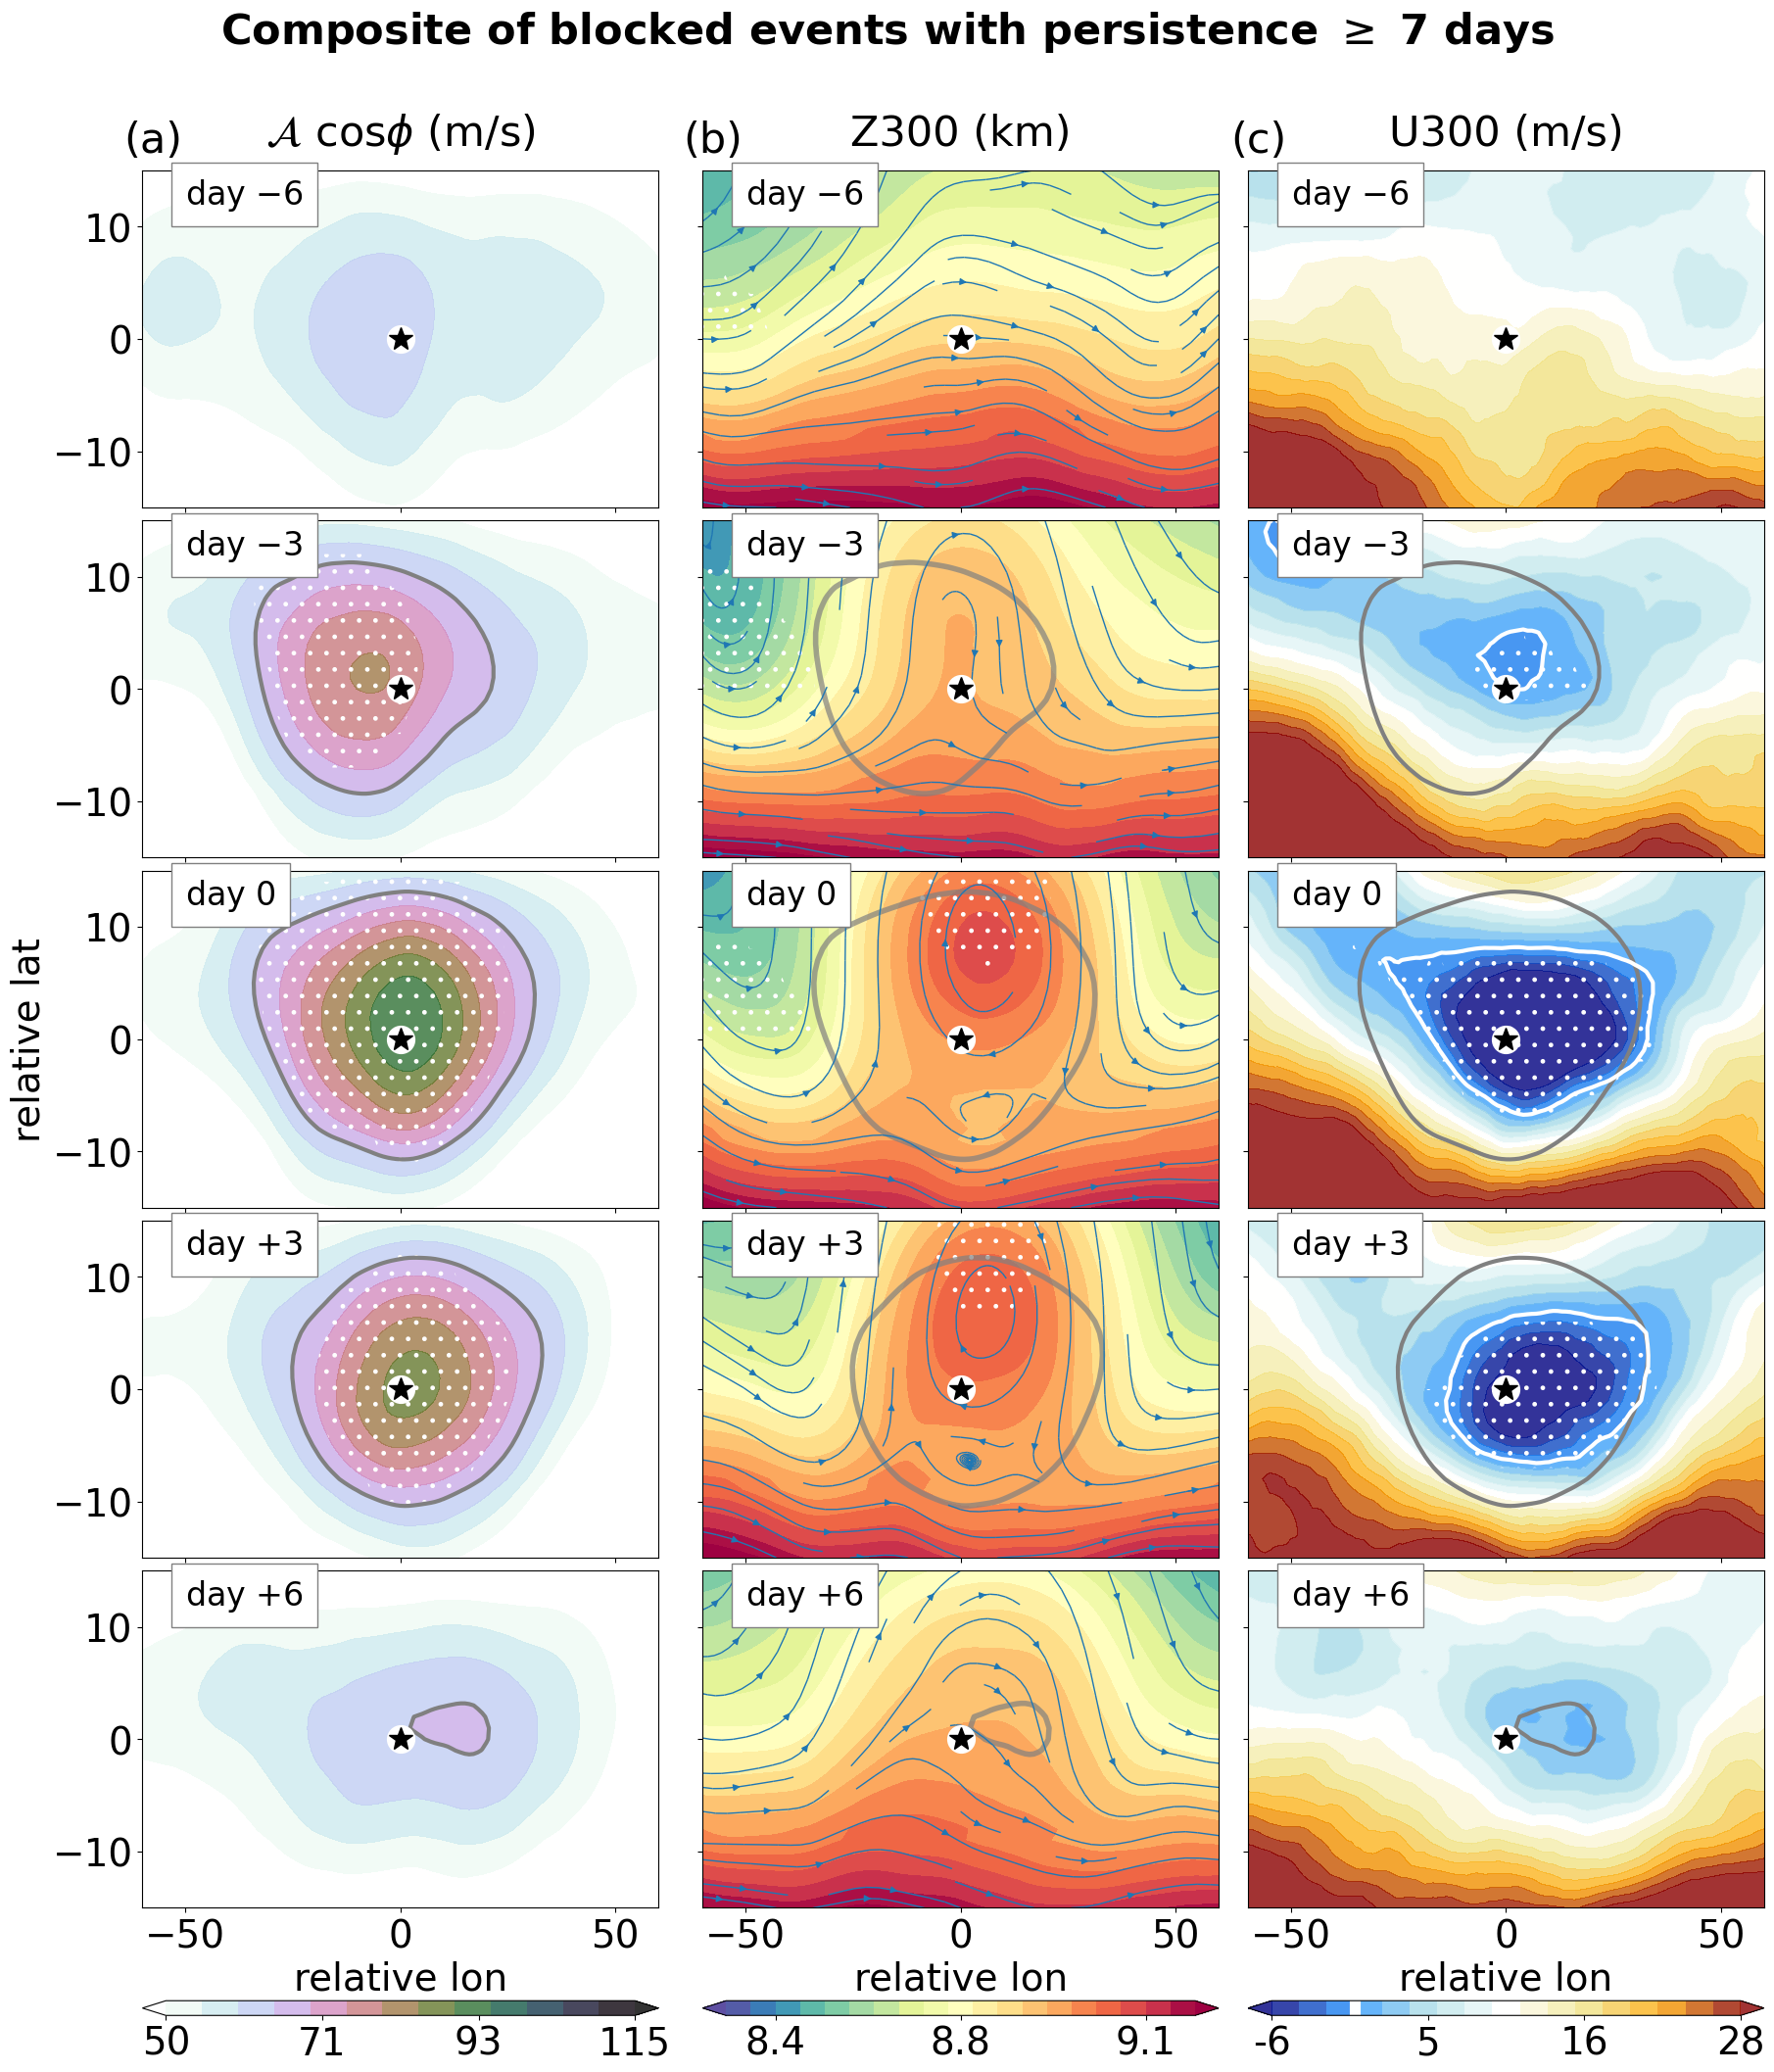

In [53]:
cmap2=py.cm.Spectral_r
LOCATION = 'global composites'

py.rcParams.update({'hatch.color': 'white', 'hatch.linewidth':1})
fig, dictionary, boostrap_dictionary = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                      lrange0 = np.arange(82, 89.8, 0.4)/9.8, \
                                      lrange1 = np.arange(-6,30,2), \
                                      lrange2 = np.arange(50, 120, 5), days = np.arange(7,19,1), \
                                      block_type='all_blocks', threshold=65, fontsize=28, \
                                      total_data_dictionary=all_blocks_dictionary, \
                                      CI=[15, 85], hatches=['.'], Nday_extra=0, Nday_less=0, gap=3, col_frac=18, row_frac=1.6)

dest = './'
os.makedirs(dest, exist_ok=True)
fig.savefig(dest+'LWA_event_composites_2d.png', dpi=300, bbox_inches='tight')
fig.savefig(dest+'LWA_event_composites_2d.pdf', bbox_inches='tight')
fig.show()


In [42]:
dictionary.keys()

dict_keys(['BLOCK_window_list_PV300_full', 'BLOCK_window_list_U300_full', 'BLOCK_window_list_Uvert_full', 'BLOCK_window_list_V300_full', 'BLOCK_window_list_Z300_full', 'coord', 'block_size', 'persistence', 'BLOCK_window_list_A_full_unfiltered', 'BLOCK_window_list_F1_full_unfiltered', 'BLOCK_window_list_F2_full_unfiltered', 'BLOCK_window_list_F3_full_unfiltered', 'BLOCK_window_list_F_EPy_full_unfiltered', 'BLOCK_window_list_F_EPz_full_unfiltered', 'BLOCK_window_list_F_full_unfiltered', 'BLOCK_window_list_A_full_synoptic', 'BLOCK_window_list_F1_full_synoptic', 'BLOCK_window_list_F2_full_synoptic', 'BLOCK_window_list_F3_full_synoptic', 'BLOCK_window_list_F_EPy_full_synoptic', 'BLOCK_window_list_F_EPz_full_synoptic', 'BLOCK_window_list_F_full_synoptic'])

In [49]:
boostrap_dictionary.keys()

dict_keys(['BLOCK_window_list_U300_full', 'BLOCK_window_list_Z300_full', 'BLOCK_window_list_A_full_synoptic'])

In [52]:
boostrap_dictionary['BLOCK_window_list_A_full_synoptic']['mean'].shape ### There are 18 regions.

(18, 29, 31, 121)

In [45]:
dictionary['BLOCK_window_list_A_full_unfiltered'].shape

(72, 29, 31, 121)

In [12]:
%%time
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
LWA_based_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_LWA_based.hkl')

CPU times: user 5.58 s, sys: 20.2 s, total: 25.7 s
Wall time: 1min 5s


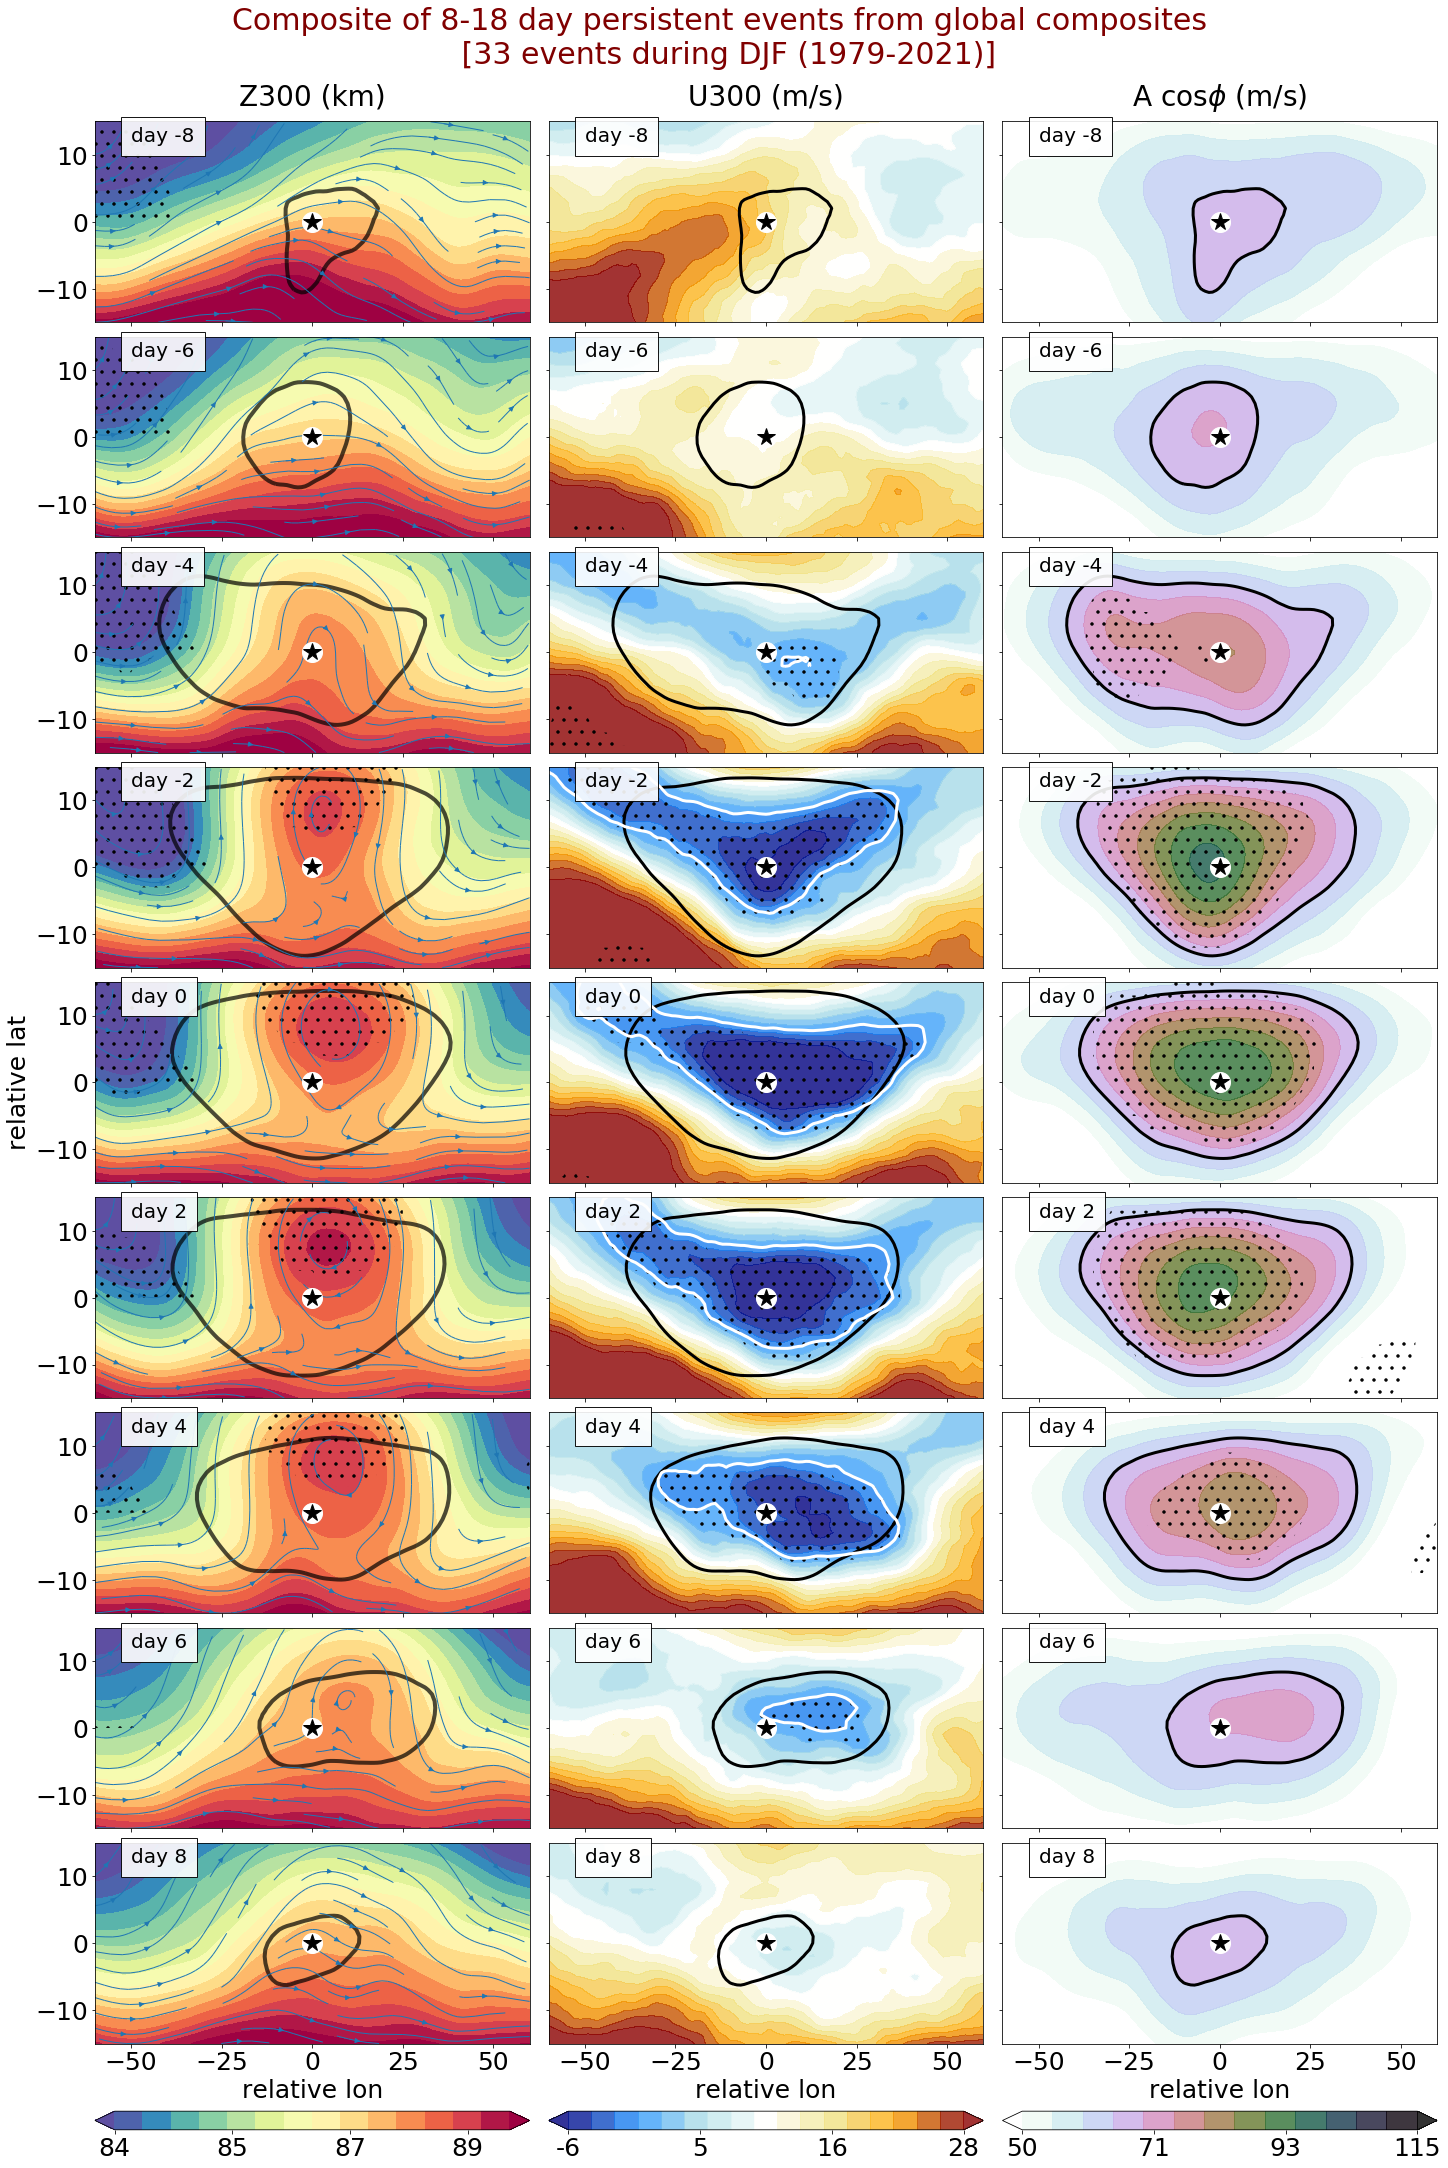

In [18]:
cmap2=py.cm.Spectral_r
LOCATION = 'global composites'
fig = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                  lrange0 = np.arange(84, 89.8, 0.4), \
                                  lrange1 = np.arange(-6,30,2), \
                                  lrange2 = np.arange(50, 120, 5), days = np.arange(8,19,1), \
                                  block_type='anticyclonic', figsize=(20, 30), threshold=65, columns = 9, default_fontsize=25, \
                                  total_data_dictionary=LWA_based_blocks_dictionary, \
                                  CI=[15, 85], hatches=['.'])

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Block_evolve_8-14_globe.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Block_evolve_8-14_globe.pdf', bbox_inches='tight')

In [13]:
%%time
source = '/data/pragallva/2023_repeat_ERA5/post_processing/combined_data_blocking/'
Z300_based_blocks_dictionary            = hkl.load(source+'/BlOCK_TYPES_DIVISION_Z300_based.hkl')

CPU times: user 4.9 s, sys: 20.1 s, total: 25 s
Wall time: 1min 4s


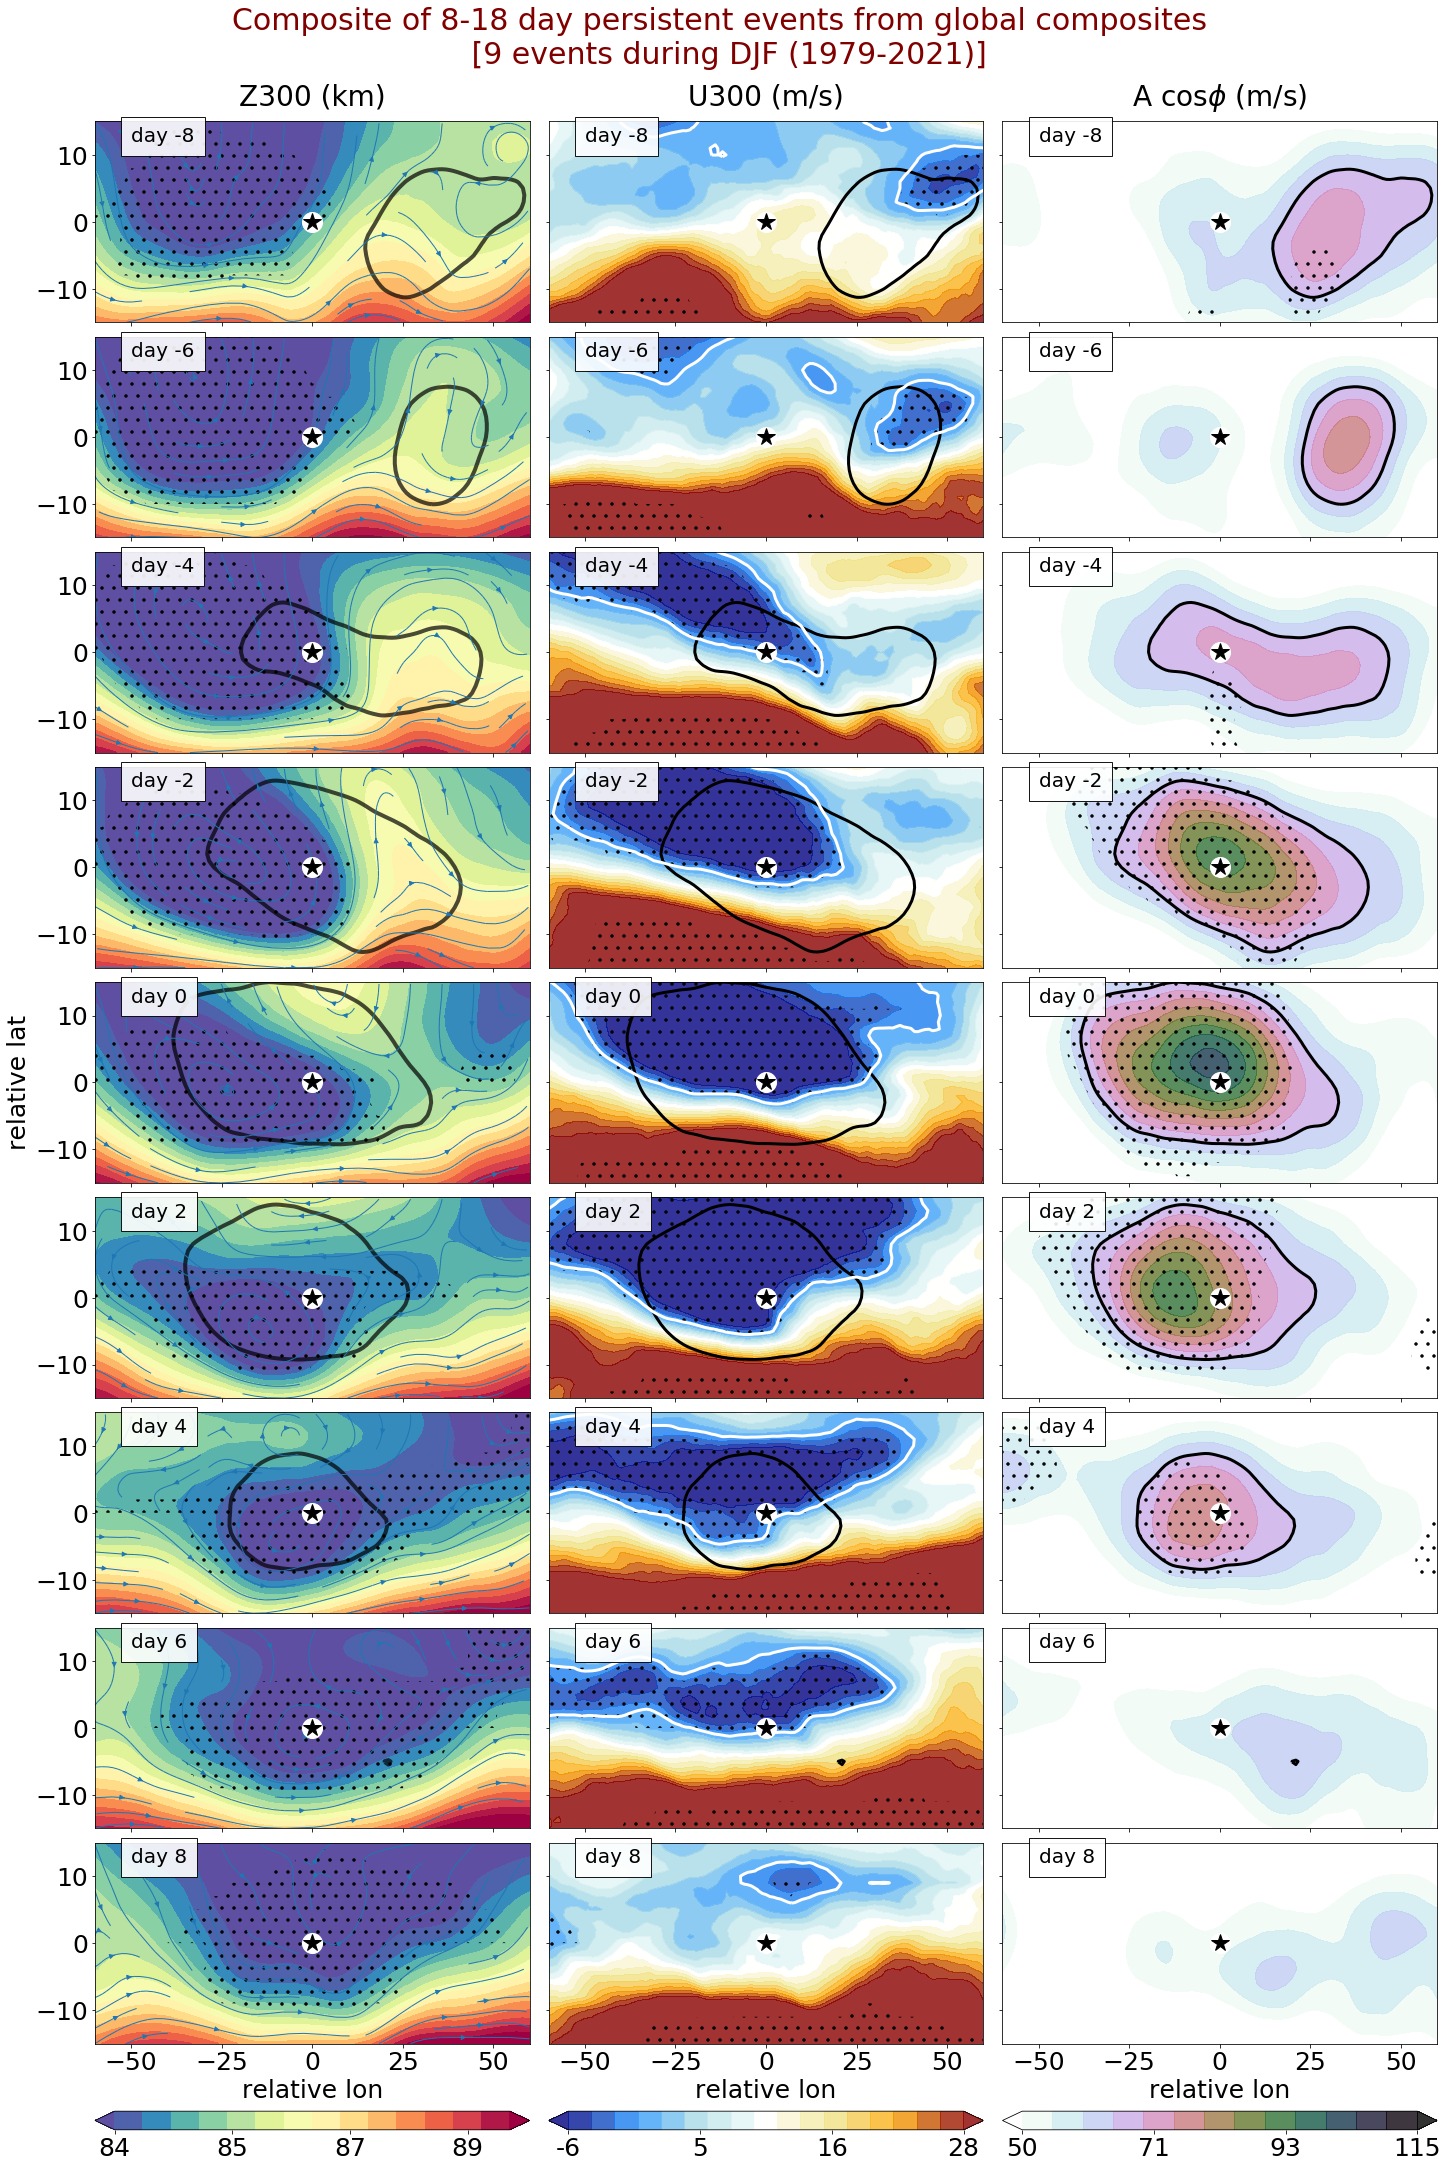

In [14]:
cmap2=py.cm.Spectral_r
LOCATION = 'global composites'
fig = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                  lrange0 = np.arange(84, 89.8, 0.4), \
                                  lrange1 = np.arange(-6,30,2), \
                                  lrange2 = np.arange(50, 120, 5), days = np.arange(8,19,1), \
                                  block_type='cyclonic', figsize=(20, 30), threshold=65, columns = 9, default_fontsize=25, \
                                  total_data_dictionary=Z300_based_blocks_dictionary, \
                                  CI=[15, 85], hatches=['.'])

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Block_evolve_8-14_globe.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Block_evolve_8-14_globe.pdf', bbox_inches='tight')

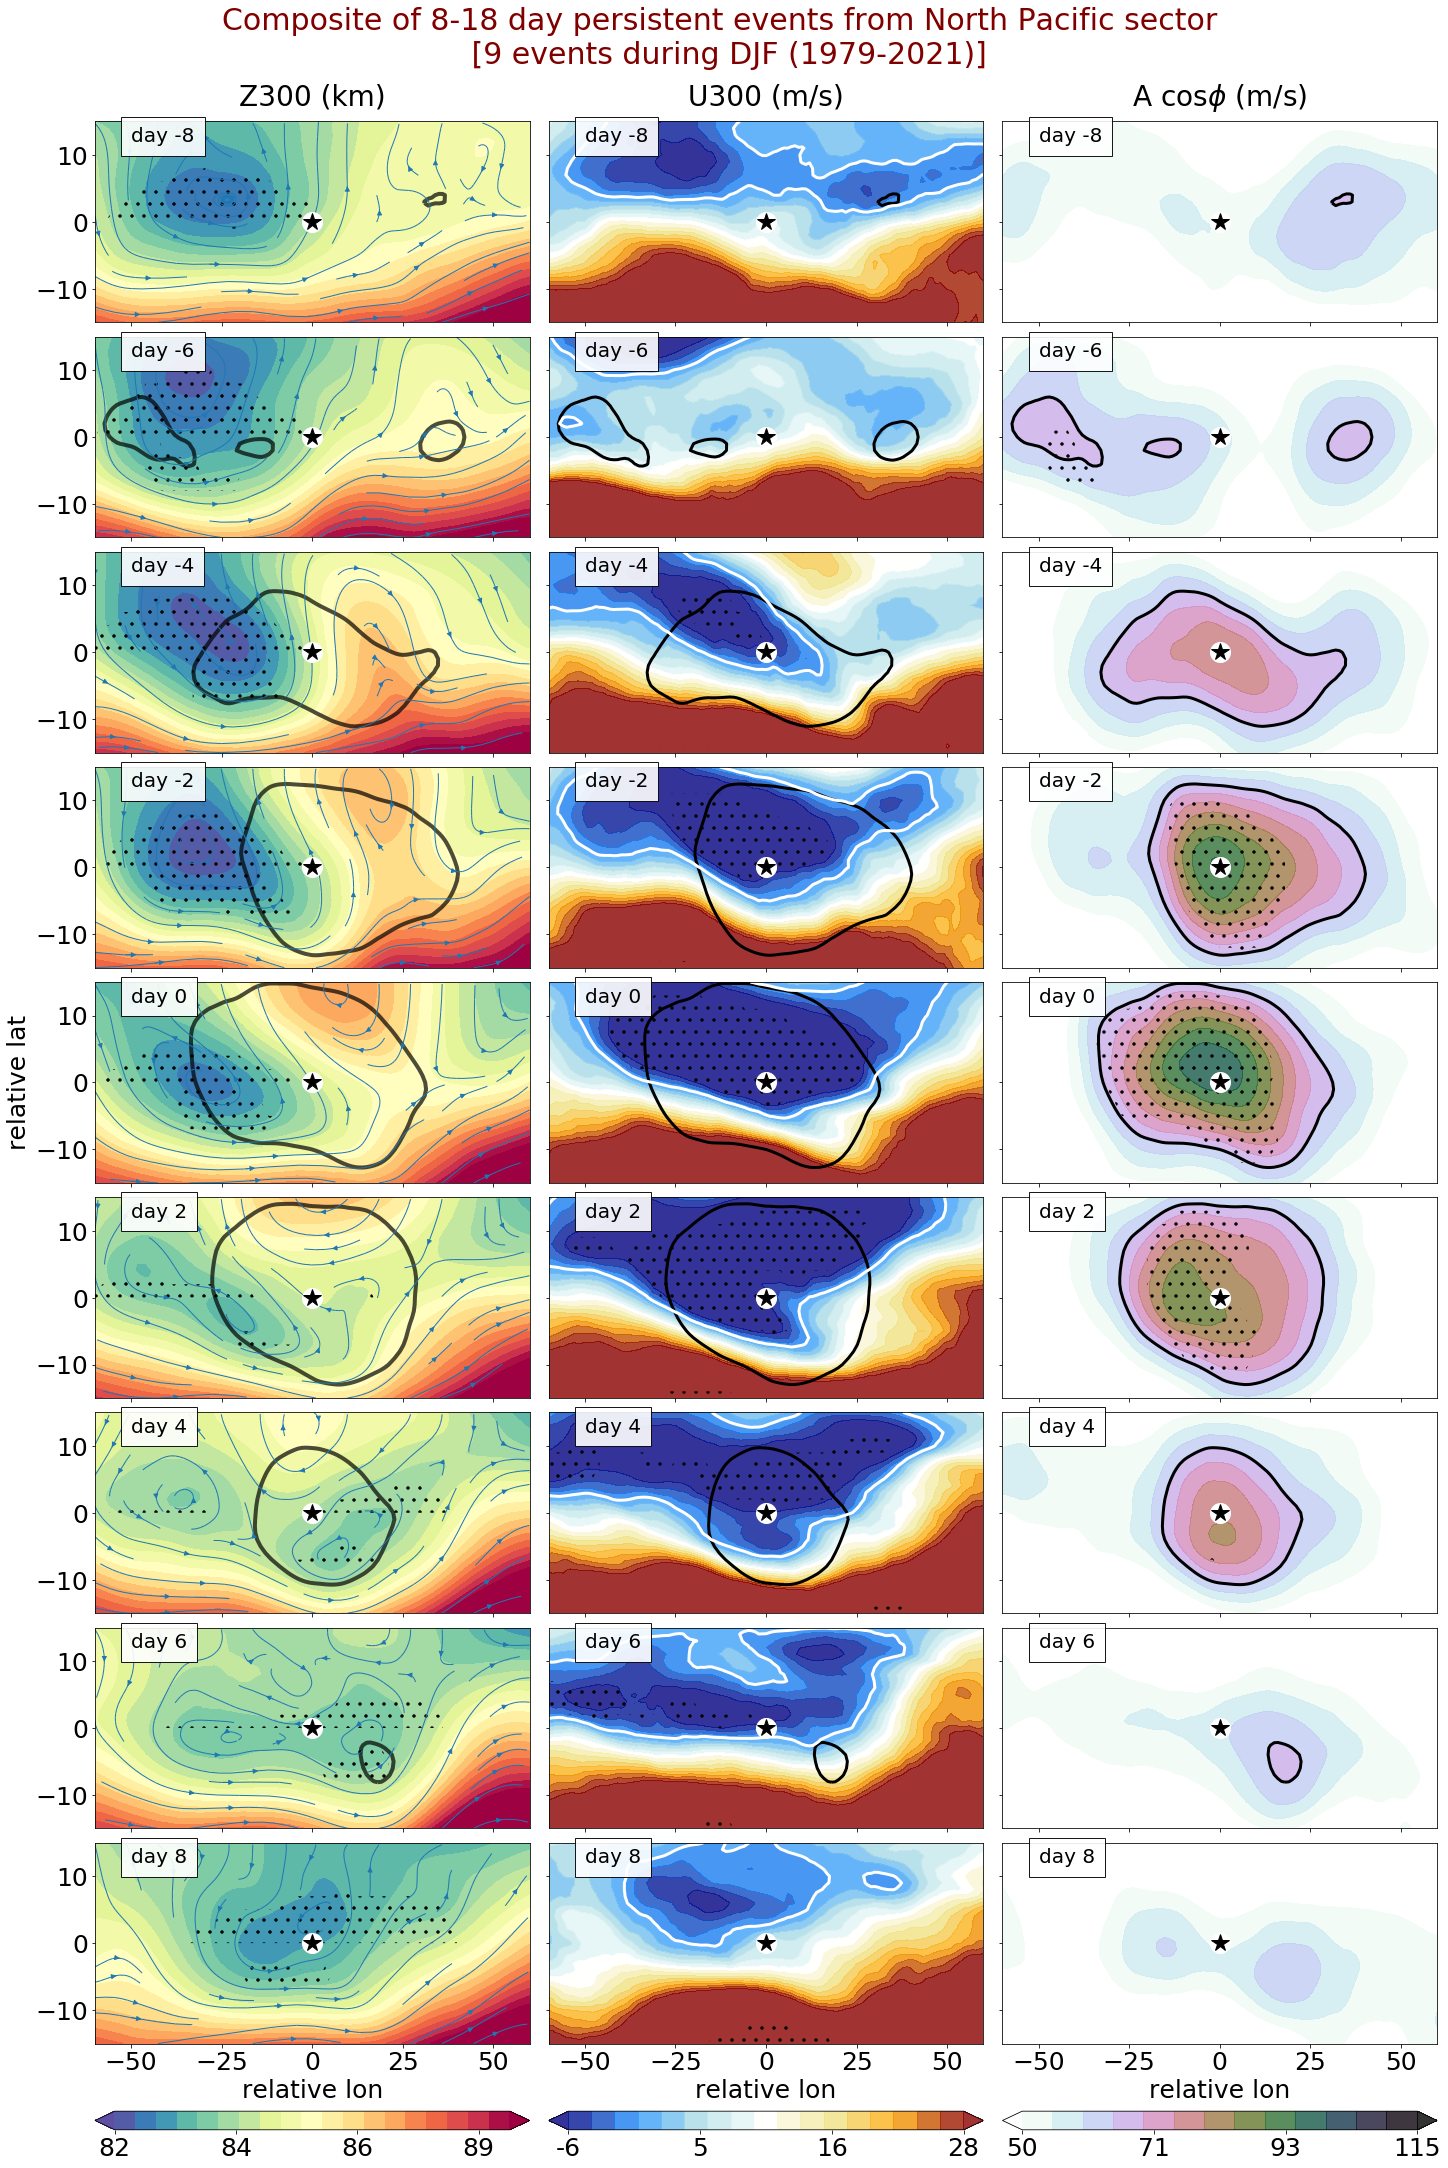

In [17]:
cmap2=py.cm.Spectral_r
LOCATION = 'North Pacific sector'
fig = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                  lrange0 = np.arange(82, 89.8, 0.4), \
                                  lrange1 = np.arange(-6,30,2), \
                                  lrange2 = np.arange(50, 120, 5), days = np.arange(8,19,1), \
                                  block_type='all_blocks', figsize=(20, 30), threshold=65, columns = 9, default_fontsize=25, \
                                  total_data_dictionary=all_blocks_dictionary, \
                                  CI=[5, 95], hatches=['.'])

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Block_evolve_8-14_globe.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Block_evolve_8-14_globe.pdf', bbox_inches='tight')

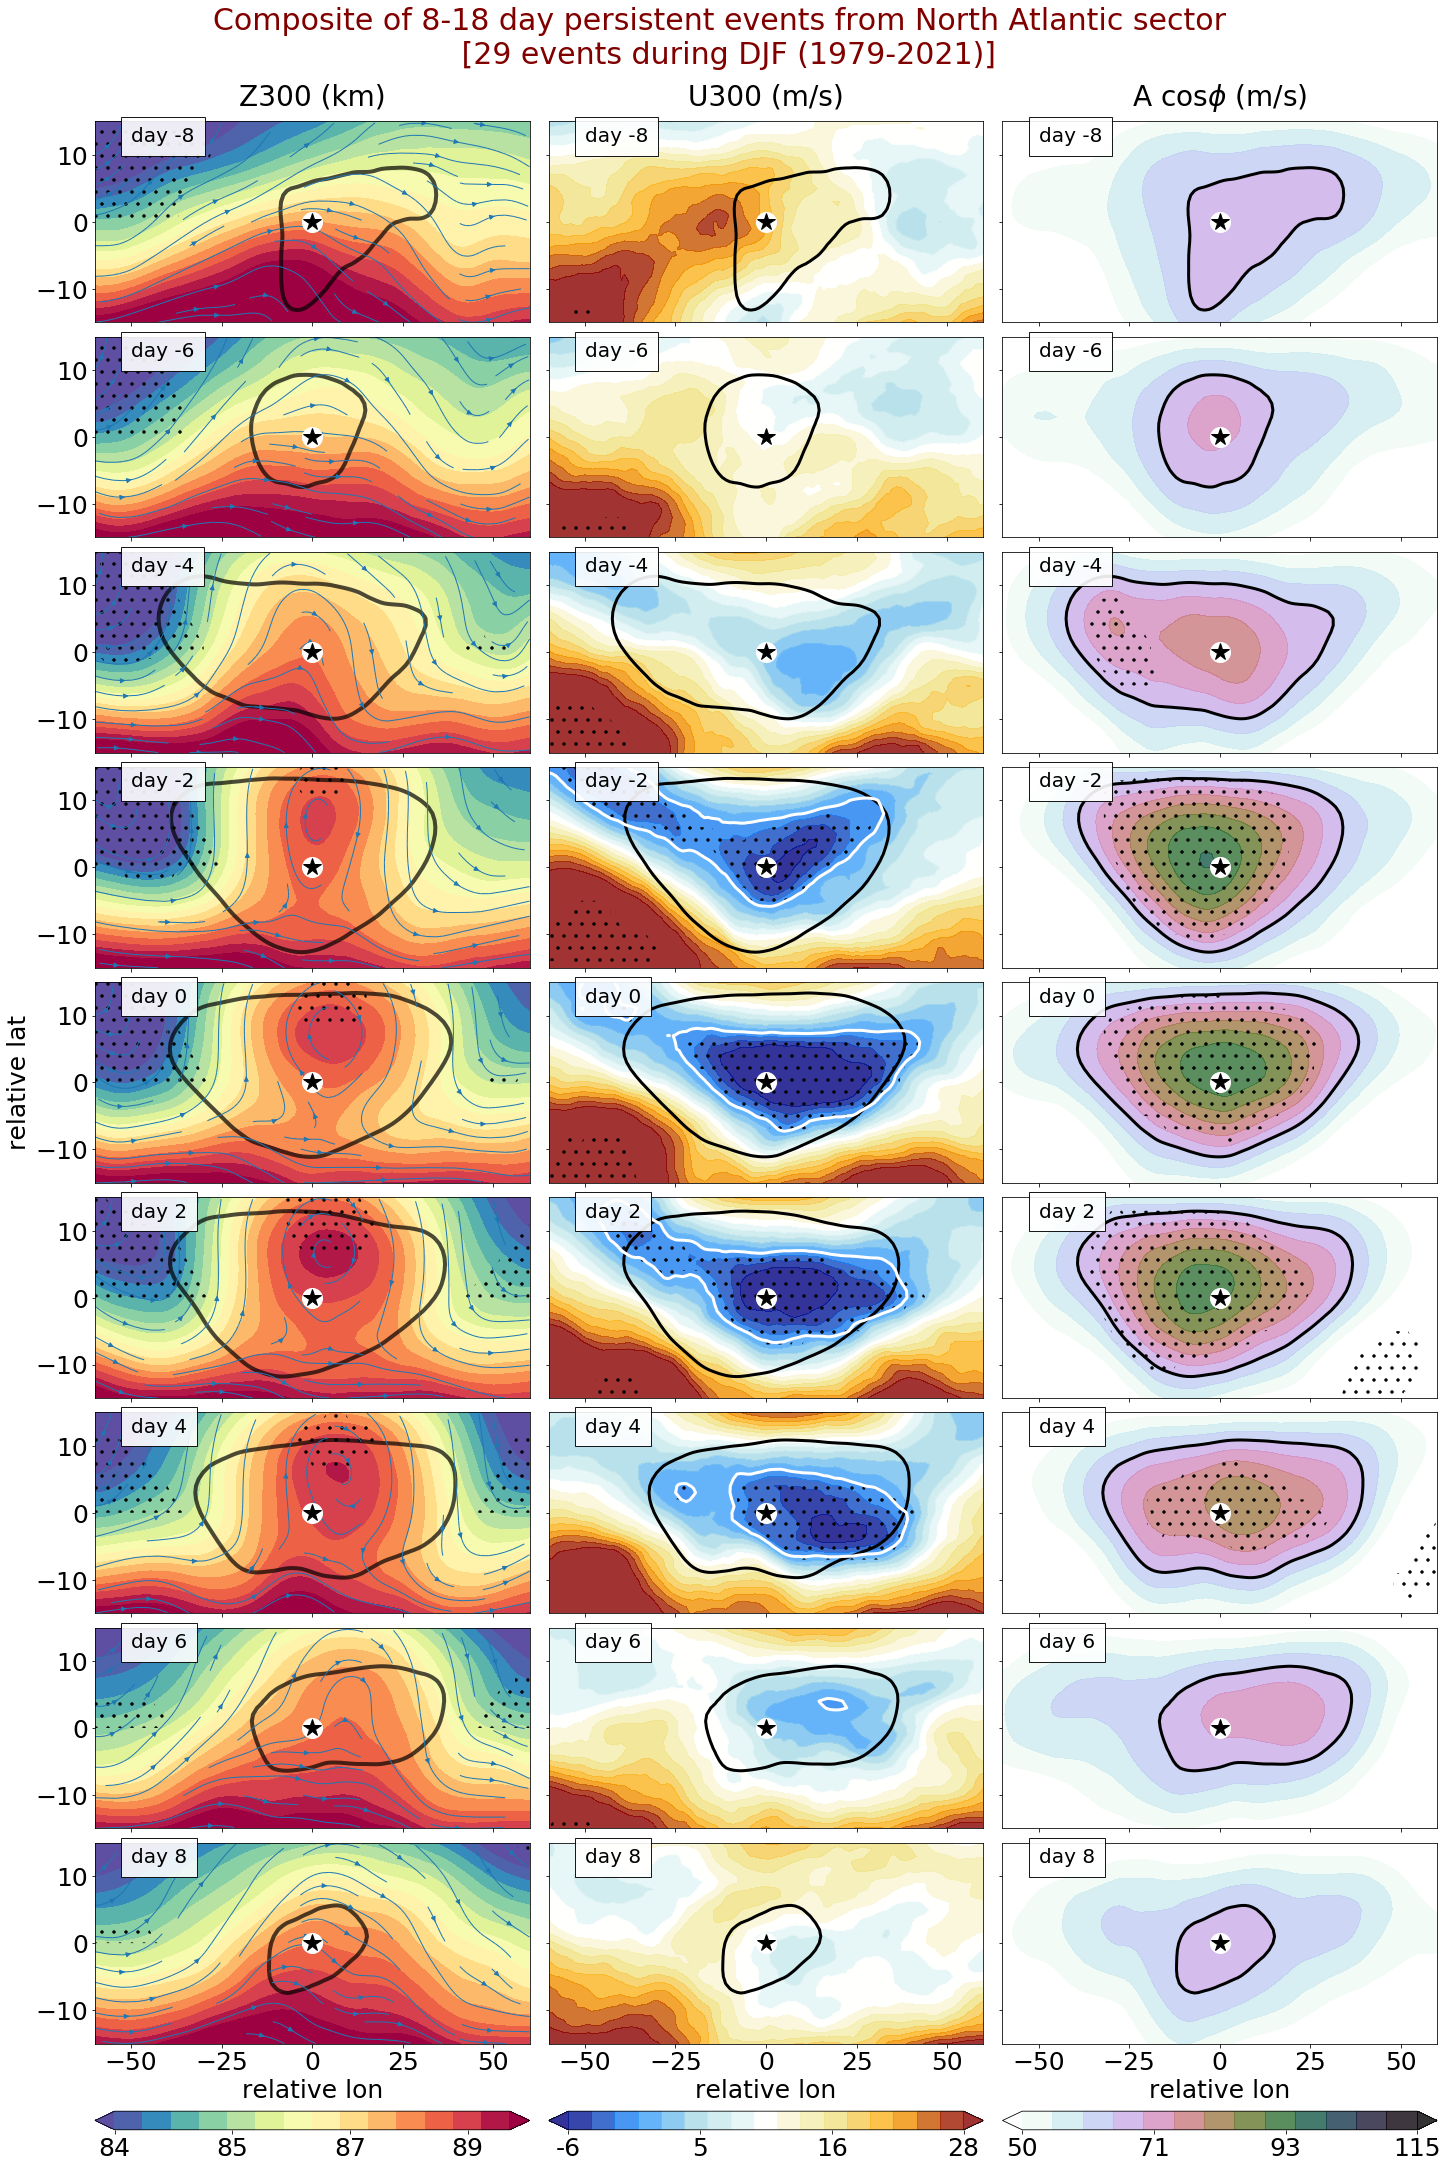

In [69]:
cmap2=py.cm.Spectral_r
LOCATION = 'North Atlantic sector'
fig = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                  lrange0 = np.arange(84, 89.8, 0.4), \
                                  lrange1 = np.arange(-6,30,2), \
                                  lrange2 = np.arange(50, 120, 5), days = np.arange(8,19,1), \
                                  block_type='all_blocks', figsize=(20, 30), threshold=65, columns = 9, default_fontsize=25, \
                                  total_data_dictionary=all_blocks_dictionary, \
                                  CI=[15, 85], hatches=['.'])

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Block_evolve_8-14_globe.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Block_evolve_8-14_globe.pdf', bbox_inches='tight')

In [ ]:
cmap2=py.cm.Spectral_r
LOCATION = 'North Atlantic sector'
fig = plot_block_evolution_for_a_region(regions = REGIONS_VARIABLE_NAMES[LOCATION], LOCATION=LOCATION, \
                                  lrange0 = np.arange(84, 89.8, 0.4), \
                                  lrange1 = np.arange(-6,30,2), \
                                  lrange2 = np.arange(50, 120, 5), days = np.arange(8,19,1), \
                                  block_type='all_blocks', figsize=(20, 30), threshold=65, columns = 9, default_fontsize=25, \
                                  total_data_dictionary=all_blocks_dictionary, \
                                  CI=[15, 85], hatches=['.'])

# dest = '/data/pragallva/2023_repeat_ERA5/jupyter_notebooks/notebooks_to_finalise_paper_figures/paper_figures/'
# os.makedirs(dest, exist_ok=True)
# fig.savefig(dest+'Block_evolve_8-14_globe.png', dpi=300, bbox_inches='tight')
# fig.savefig(dest+'Block_evolve_8-14_globe.pdf', bbox_inches='tight')